In [1]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
library(tidyverse)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

Loading required package: sysfonts
Loading required package: showtextdb
Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()


# Data loading and visualization

## Loading

In [2]:
data_ACC <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 


## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

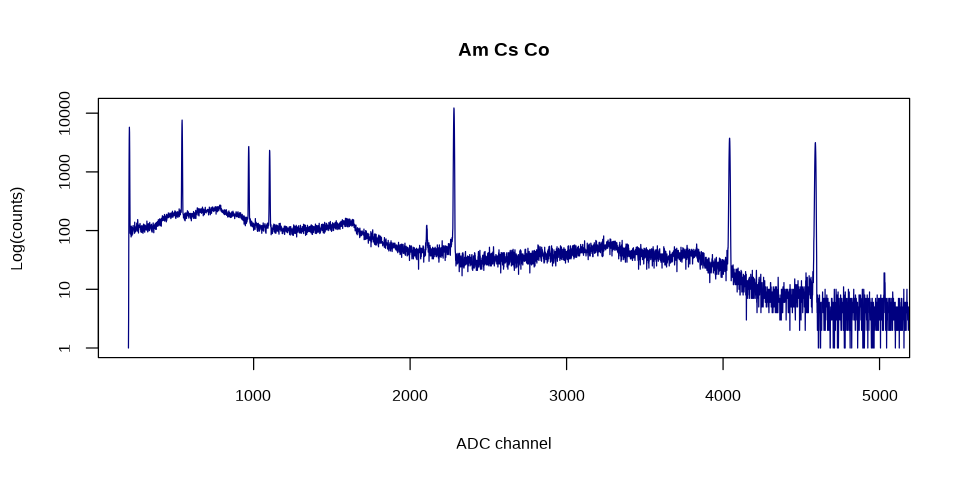

In [3]:
set_plot_dimensions(8, 4)

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## Additional  Information

In [4]:
ACC_energies <-c(59.5409,661.657,1173.228,1332.51)
df_ACC <- data.frame(ACC_energies)
row.names(df_ACC)<-c("Am","Cs","Co_1","Co_2")
df_ACC


,ACC_energies
Am,59.5409
Cs,661.6570
Co_1,1173.2280
Co_2,1332.5100


## Peak detection and characterization

In [5]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}

peak_shift <- function(peak_array){
    #fetches an array of counts with the peak at the center
    peak_idx <- which.max(peak_array)
    peak_y <- c(peak_array[(peak_idx-5):(peak_idx+5)])
    return(peak_y)
}

fetch_ch <- function(peak_array){
    #fetches indices of a particular peak as it exists in the elements of data_range
    peak_idx <- which.max(peak_array)
    idx_c <- c((peak_idx-5):(peak_idx+5))
    return(idx_c)
}

probe_peaks <- function(data, n.pts, pk_size){
    
    #split counts and channels into intervals of n.pts each
    data_range <- split(data$counts, ceiling(row(data)/n.pts))
    ch_range <- split(data$Ch, ceiling(row(data)/n.pts))
    
    #find the range of values for each interval established in data_range
    minmax_range <- lapply(data_range, range_size)
    
    #filter the counts to return peaks larger than a certain size.
    peaks <- data_range[minmax_range > pk_size]
    
    #applies functions to gather counts in each of the peaks, and their indices in data_range
    ly <- lapply(peaks, peak_shift)
    lx <- lapply(peaks, fetch_ch)
    
    #build dataframe of channel indices
    centered_ch <- bind_cols(lx)
    colnames(centered_ch) = paste('X', 1:length(lx), sep = '')
    
    #convert indices gathered from data_range to channel values according to ch_range
    for(i in seq_along(colnames(centered_ch))){
        centered_ch[[colnames(centered_ch)[i]]] = ch_range[[names(lx)[i]]][lx[[i]]]
    }
    
    #build dataframe of count values
    centered_peaks <- bind_cols(ly)
    colnames(centered_peaks) = paste('Y',1:length(ly), sep = '')
    
    #bind together channel values and count values, with "Xi" corresponding to "Yi", i = 1, 2, ...
    centered_ch %<>% cbind(centered_peaks)
    return(centered_ch)
}

centered_peaks <- probe_peaks(data_ACC, 80, 2000)

Warning message in split.default(data$counts, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”Warning message in split.default(data$Ch, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”

In [6]:
centered_peaks 

X1,X2,X3,X4,X5,X6,X7,Y1,Y2,Y3,Y4,Y5,Y6,Y7
201,538,964,1097,2275,4037,4585,3,256,182,154,586,777,742
202,539,965,1098,2276,4038,4586,48,547,350,214,1400,1528,1278
203,540,966,1099,2277,4039,4587,328,1570,788,430,3304,2232,1893
204,541,967,1100,2278,4040,4588,1458,3904,1722,958,6290,3065,2543
205,542,968,1101,2279,4041,4589,3690,6510,2593,1712,9826,3683,3074
206,543,969,1102,2280,4042,4590,5758,7626,2703,2325,12254,3748,3153
207,544,970,1103,2281,4043,4591,4707,5680,2070,2215,11765,3275,2724
208,545,971,1104,2282,4044,4592,2114,2856,1192,1602,8721,2357,2156
209,546,972,1105,2283,4045,4593,568,1074,537,900,5231,1484,1524
210,547,973,1106,2284,4046,4594,181,386,239,414,2355,817,863


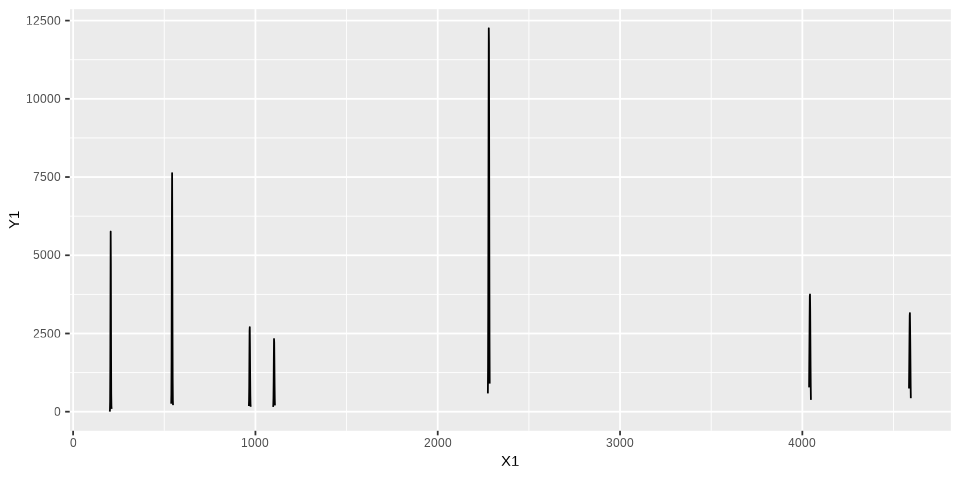

In [7]:
ggplot(data=centered_peaks)+geom_line(aes(X1,Y1))+
geom_line(aes(X2,Y2))+
geom_line(aes(X3,Y3))+
geom_line(aes(X4,Y4))+
geom_line(aes(X5,Y5))+
geom_line(aes(X6,Y6))+
geom_line(aes(X7,Y7))

# Peak processing 

In [8]:
t1 <- NULL
t1$x <- centered_peaks$X1[centered_peaks$Y1!=0]
t1$y <- centered_peaks$Y1[centered_peaks$Y1!=0]

t2 <- NULL
t2$x <- centered_peaks$X2
t2$y <- centered_peaks$Y2

t3 <- NULL
t3$x <- centered_peaks$X3
t3$y <- centered_peaks$Y3

t4 <- NULL
t4$x <- centered_peaks$X4
t4$y <- centered_peaks$Y4


peaks <-list(t1,t2,t3,t4)

In [9]:
peak_properties <- function (peaks){
i=1
chains <-c()
x0_mean <-c()
x0_std <-c()
w_mean <-c()
w_std <-c()

for (pk in peaks){

#Plot of the choosen peak
set_plot_dimensions(4, 4)
plot(pk$x,pk$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel",
    main=paste("peak",i))

A.min <- min(pk$y)
A.max <- max(pk$y)
B.min <- 0
B.max <- max(c(min(pk$y[1:floor(length(pk$y)/2)]),min(pk$y[floor(length(pk$y)/2):length(pk$y)])))  #This is a critical point for peaks that doesn't have a
                     #a stable noise around so min(pk$y) is not representative
x0.min <- min(pk$x)  
x0.max <- max(pk$x)

cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dnorm(",A.max,",",50,")
    B ~ dnorm(",B.max,",",10,")

    x0 ~ dunif(",x0.min,",",x0.max,")
    w ~ dunif(1,10)
      
}", file=paste("Models/model_peak_",i,".bug",sep=""))

model <- paste("Models/model_peak_",i,".bug",sep="")


#If multiple chains are run, each of them need to be initialized
init <- NULL;init$A  <- (A.max-A.min)/2
init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

#To have absolute control we also set the seed for and random number generator for each chain
init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10


jm <- jags.model(model,
                 pk,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
chains <- append(chains,list(chain))
#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
#plot(chain)
print(paste("peak",i))
print(summary(chain))

A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x0_mean <- c(x0_mean,x0)
x0_std  <- c(x0_std,summary(chain)$statistics[4,2])
w_mean <- c(w_mean,w)
w_std  <- c(w_std,summary(chain)$statistics[3,2])
    
x <- seq(x0.min,x0.max,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


set_plot_dimensions(4, 4)
plot(pk$x,pk$y,
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')
i=i+1
}
    
results <- NULL
results$chains  <- chains
results$x0_mean <- x0_mean
results$x0_std  <- x0_std
results$w_mean  <- w_mean
results$w_std   <- w_std
    return(results)
    }

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  5757.999 0.141679 0.0025867      0.0025263
B    89.855 0.315092 0.0057528      0.0057531
w     1.262 0.006168 0.0001126      0.0001118
x0  206.184 0.009844 0.0001797      0.0001751

2. Quantiles for each variable:

      2.5%      25%      50%      75%    97.5%
A  5757.71 5757.900 5757.999 5758.096 5758.275
B    89.26   89.641   89.849   90.068   90.481
w     1.25    1.258    1.262    1.266    1.274
x0  206.17  206.177  206.183  206.191  206.203



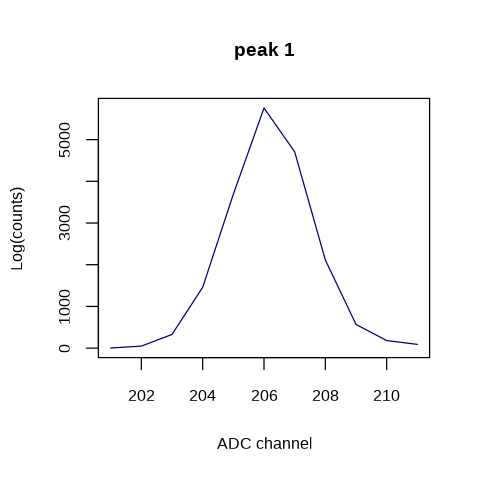

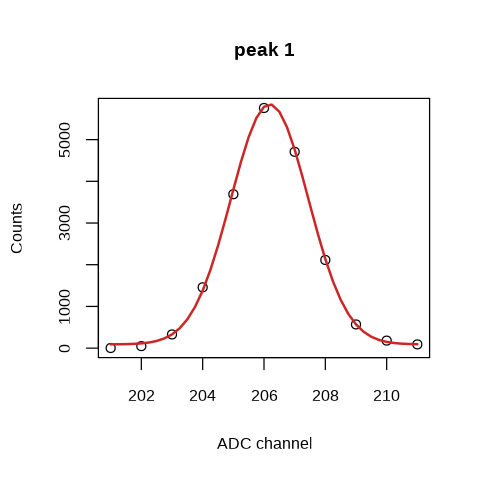

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  7625.998 0.140425 0.0025638      0.0025032
B   255.957 0.315809 0.0057659      0.0059744
w     1.488 0.006227 0.0001137      0.0001168
x0  542.816 0.009961 0.0001819      0.0001742

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  7625.729 7625.901 7625.997 7626.096 7626.274
B   255.336  255.738  255.958  256.179  256.573
w     1.476    1.484    1.488    1.493    1.501
x0  542.796  542.809  542.816  542.823  542.835



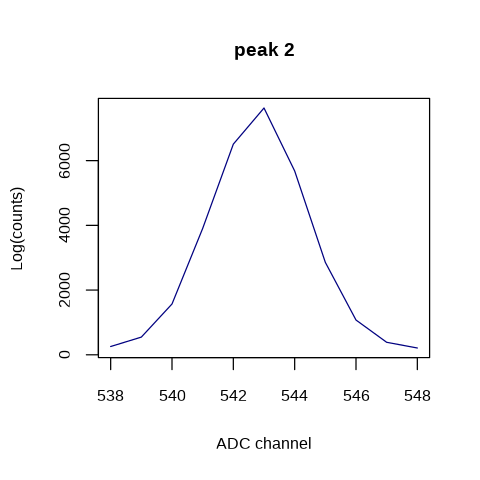

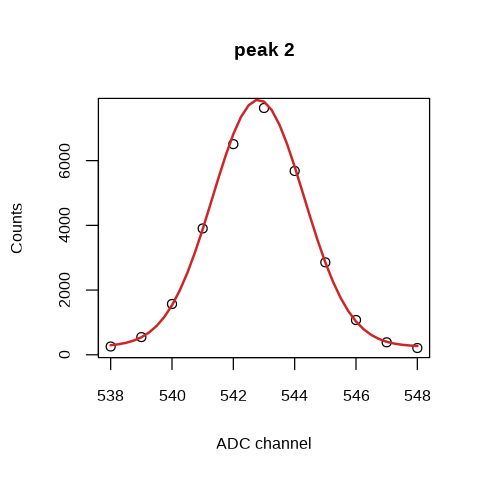

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  2702.997 0.14260 0.0026035      0.0025537
B   181.947 0.31798 0.0058056      0.0058048
w     1.589 0.01154 0.0002107      0.0002124
x0  968.727 0.01804 0.0003294      0.0003292

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  2702.714 2702.903 2702.999 2703.096 2703.282
B   181.325  181.727  181.946  182.168  182.577
w     1.567    1.581    1.589    1.596    1.613
x0  968.691  968.714  968.727  968.739  968.762



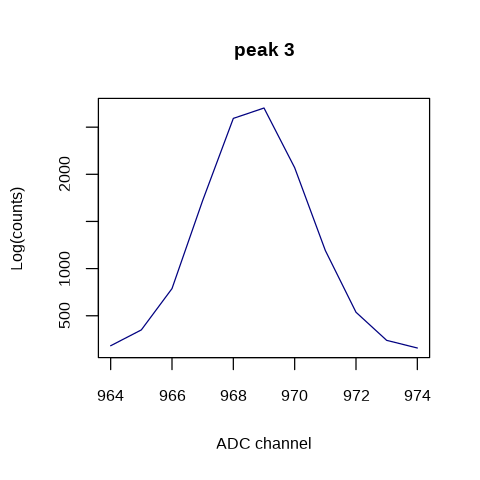

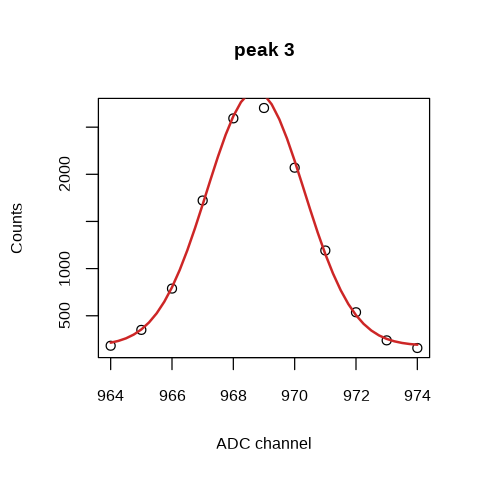

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  2325.000 0.14494 0.0026463      0.0027393
B   200.945 0.31768 0.0058000      0.0057983
w     1.597 0.01276 0.0002330      0.0002235
x0 1102.445 0.01996 0.0003644      0.0003642

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  2324.715 2324.902 2325.001 2325.101 2325.283
B   200.323  200.734  200.944  201.160  201.572
w     1.572    1.589    1.598    1.606    1.622
x0 1102.407 1102.432 1102.445 1102.459 1102.484



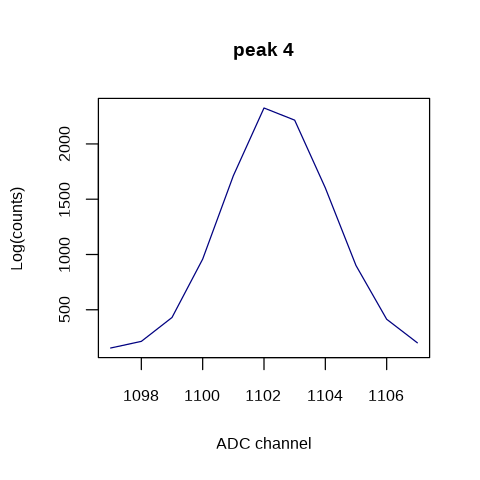

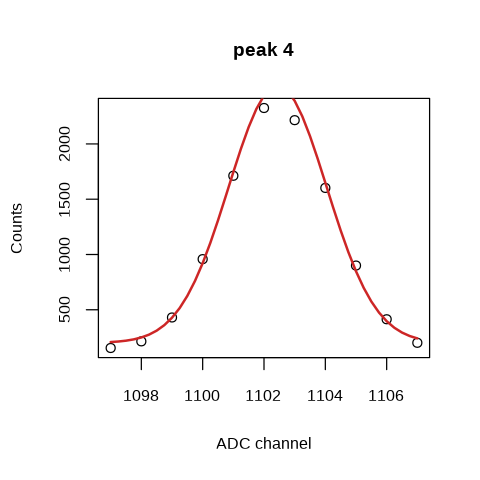

In [10]:
ACC_properties <- peak_properties(peaks)

#### Americum

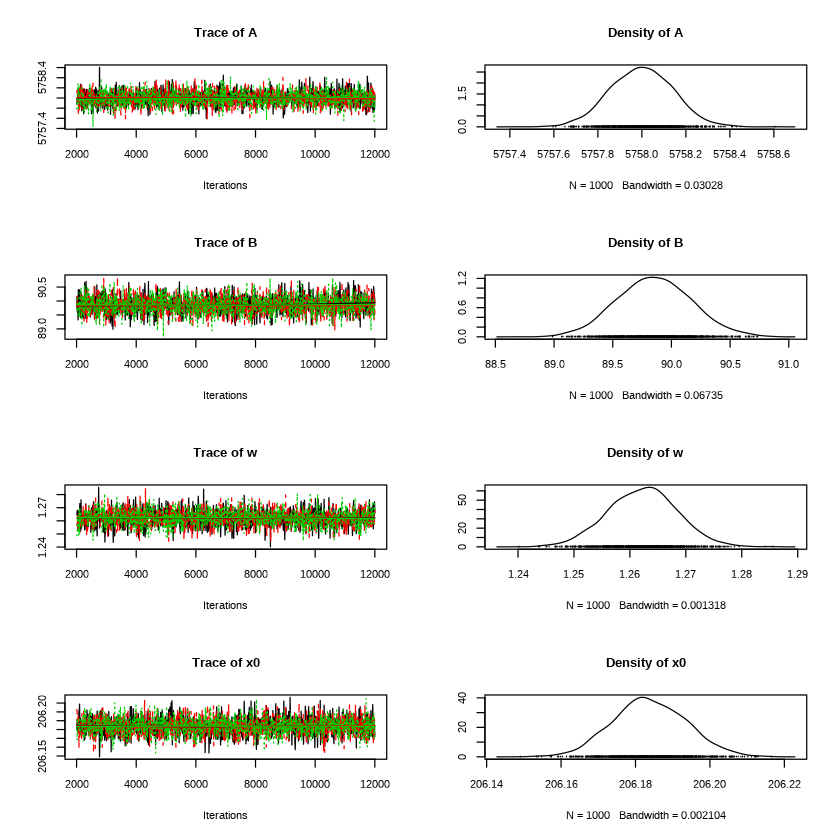

In [11]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[1]])

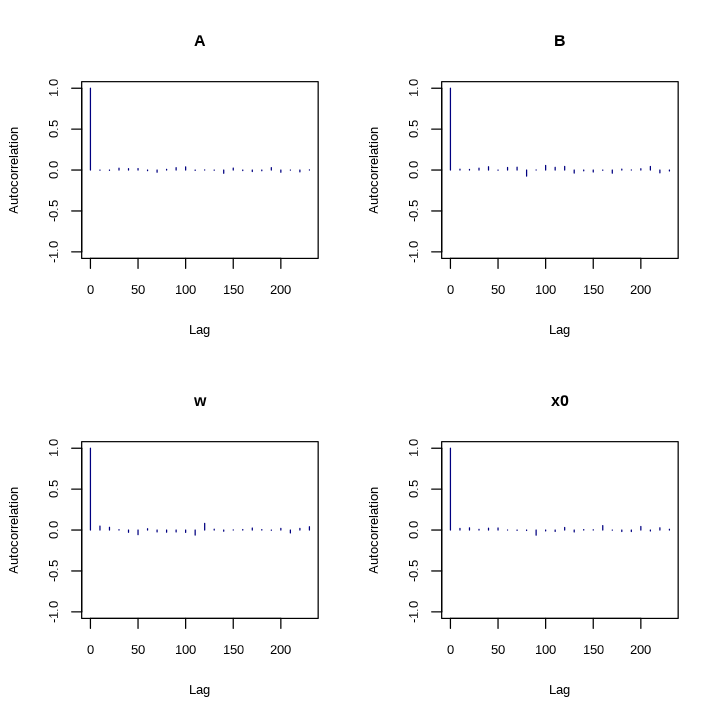

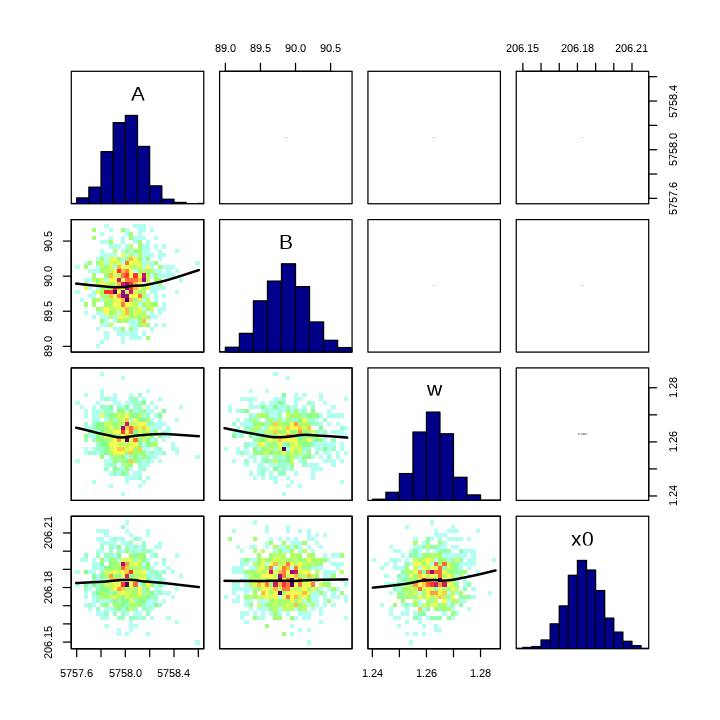

In [12]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[1]][1], col='navy')

correlationPlot((ACC_properties$chains[[1]][1]))

#### Cs

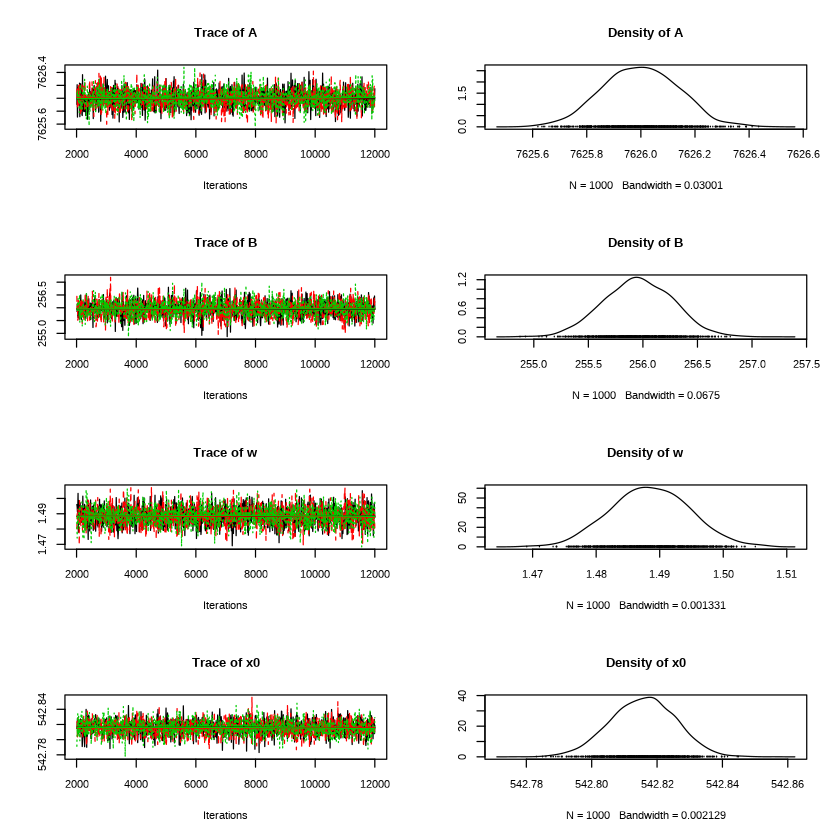

In [13]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[2]])

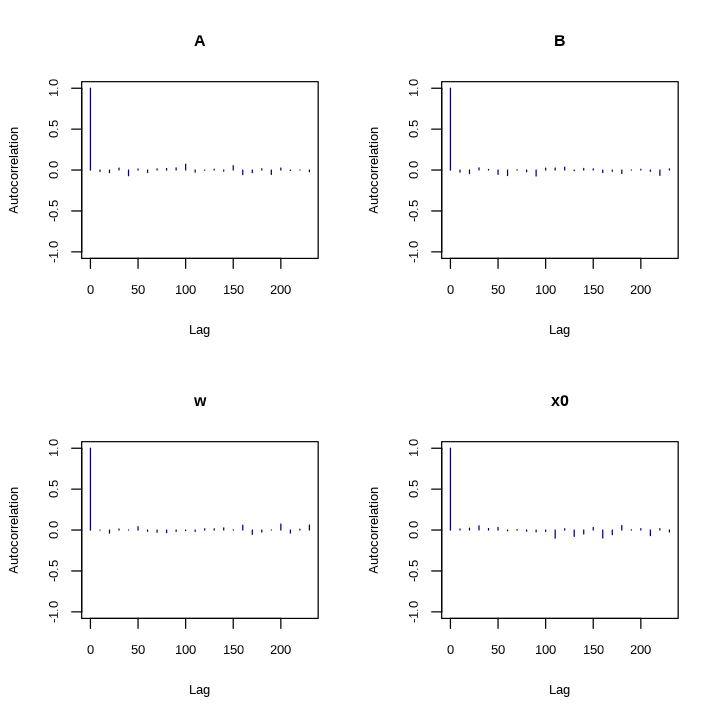

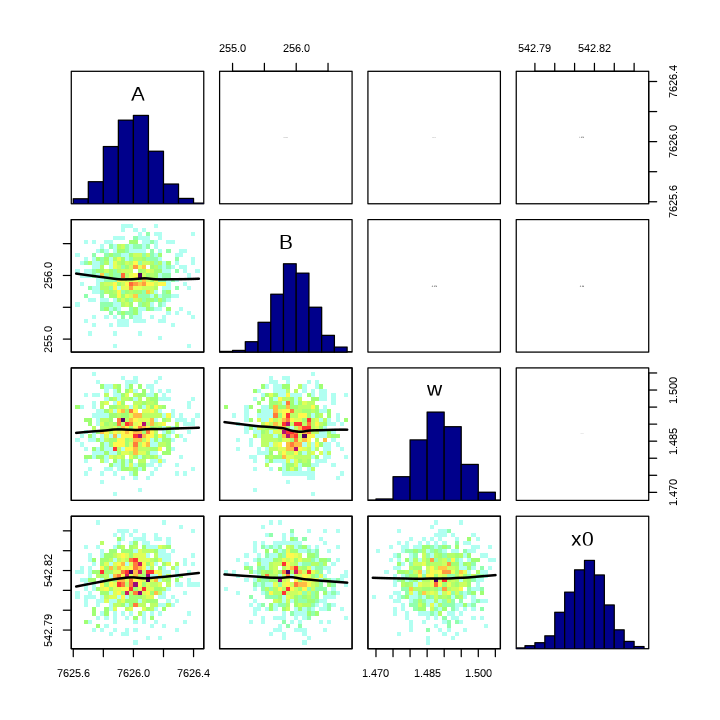

In [14]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[2]][1], col='navy')

correlationPlot((ACC_properties$chains[[2]][1]))

### Co 1

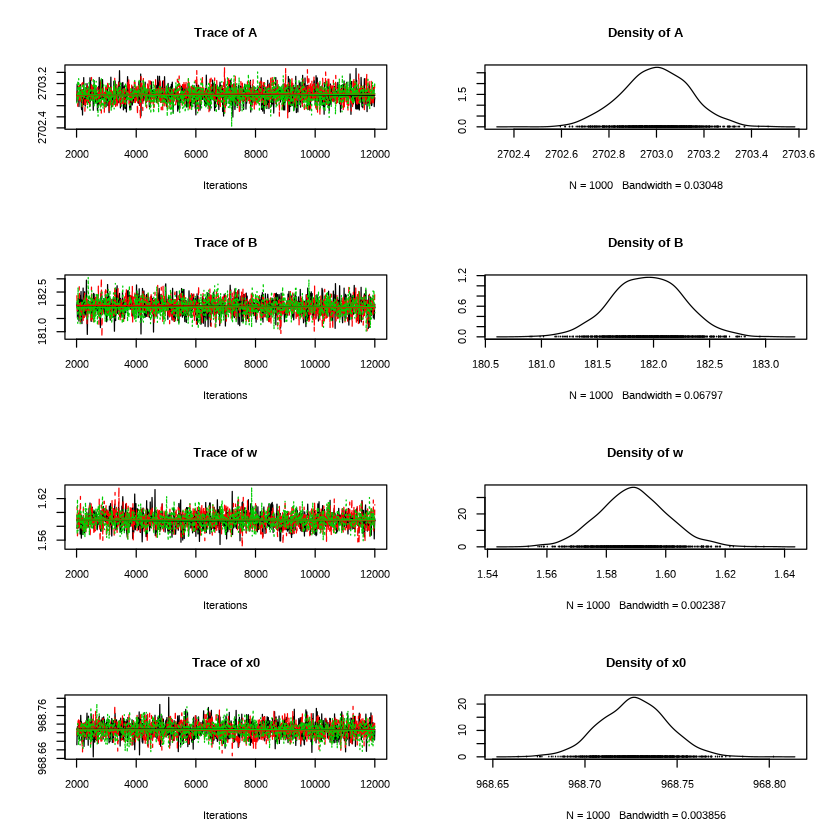

In [15]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[3]])

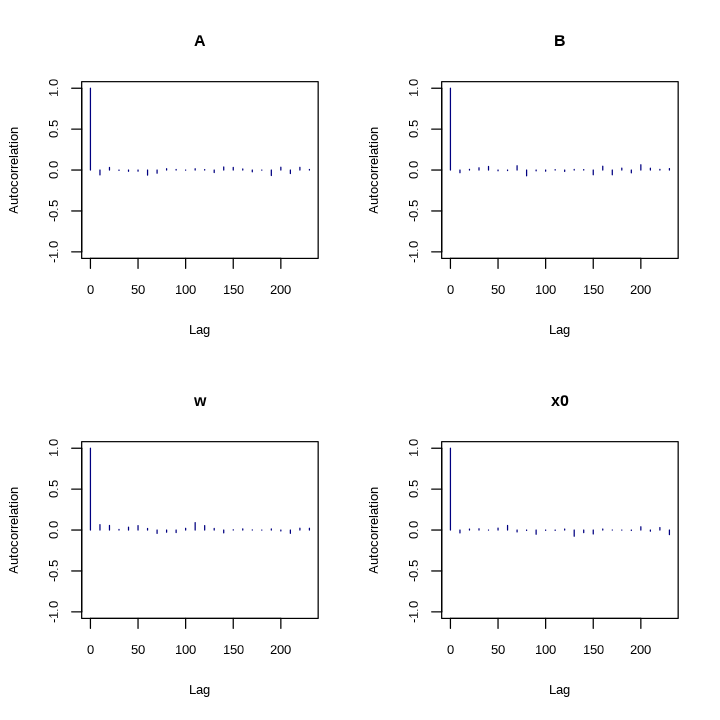

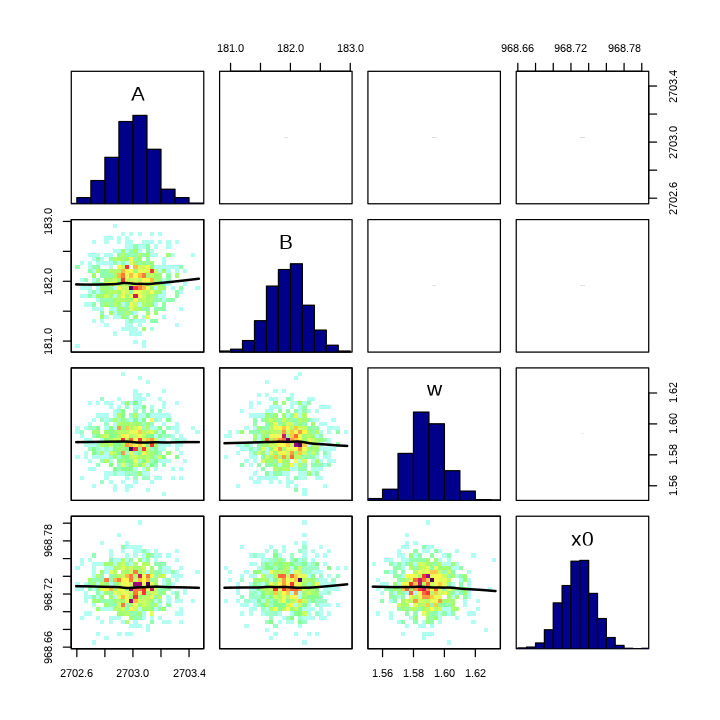

In [16]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[3]][1], col='navy')

correlationPlot((ACC_properties$chains[[3]][1]))

#### Co 2


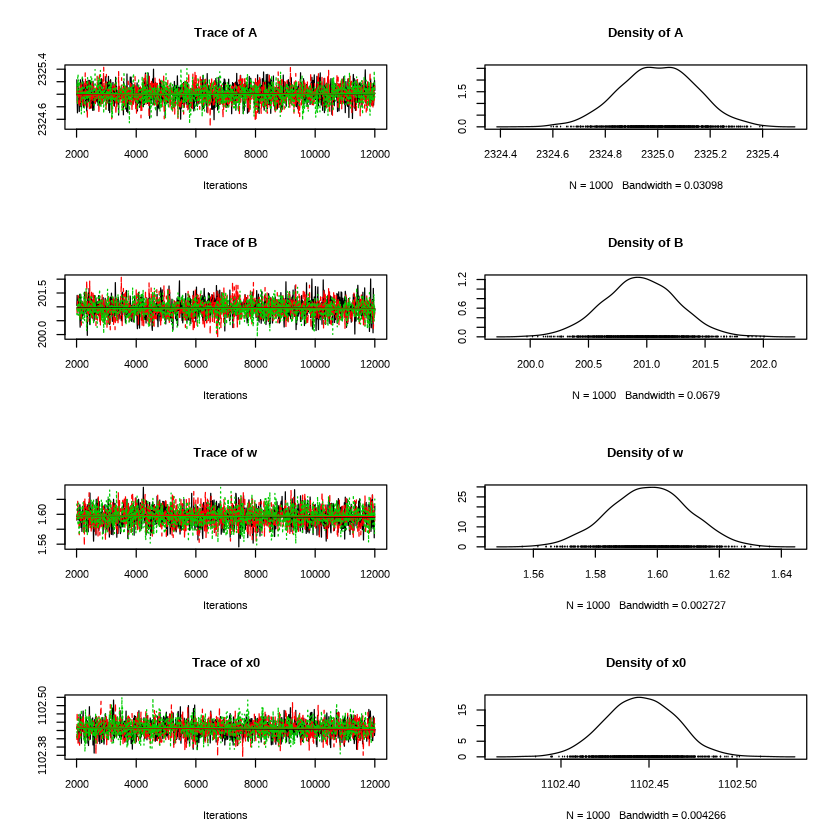

In [17]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[4]])

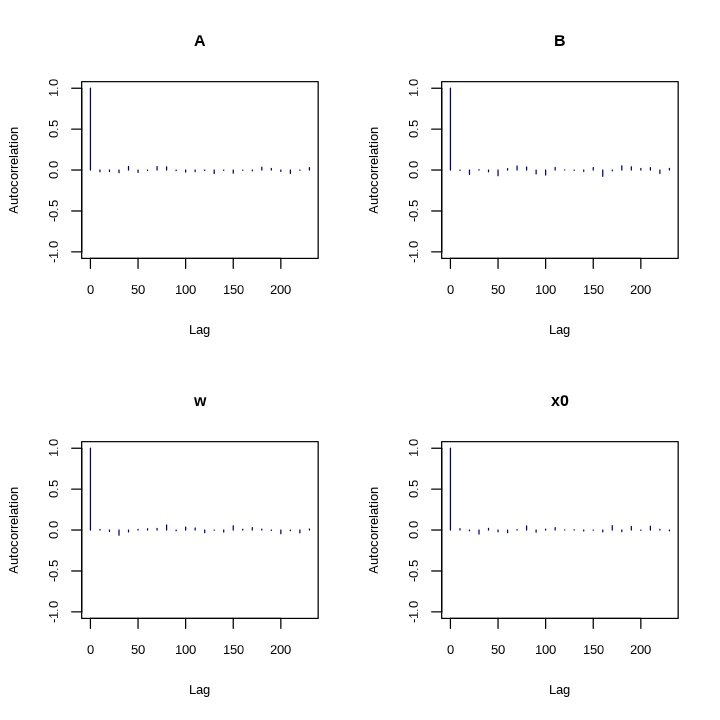

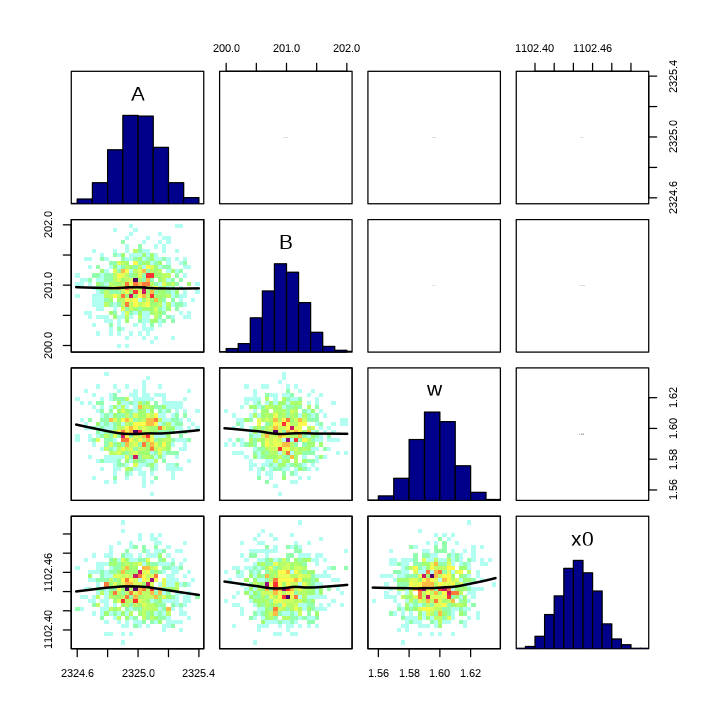

In [18]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[4]][1], col='navy')

correlationPlot((ACC_properties$chains[[4]][1]))

## Energy calibration

In [19]:
df_ACC$x0_mean <- ACC_properties$x0_mean
df_ACC$x0_std  <- ACC_properties$x0_std
df_ACC$w_mean  <- ACC_properties$w_mean
df_ACC$w_std   <- ACC_properties$w_std


In [20]:
df_ACC

,ACC_energies,x0_mean,x0_std,w_mean,w_std
Am,59.5409,206.1838,0.009843893,1.262248,0.006167627
Cs,661.6570,542.8157,0.009961485,1.488487,0.006226598
Co_1,1173.2280,968.7266,0.018039921,1.588982,0.011542862
Co_2,1332.5100,1102.4453,0.019957239,1.597347,0.012759508


In [21]:
linear_fit <- lm( df_ACC$ACC_energies ~ df_ACC$x0_mean )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
calibrated_energy <- intercept + data_ACC$Ch*slope

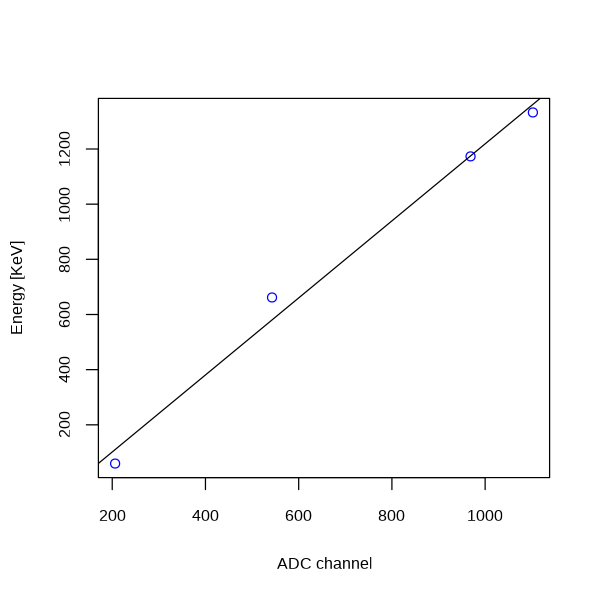

In [22]:
set_plot_dimensions(5, 5)
plot(df_ACC$x0_mean,df_ACC$ACC_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="")
lines(data_ACC$Ch,calibrated_energy)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

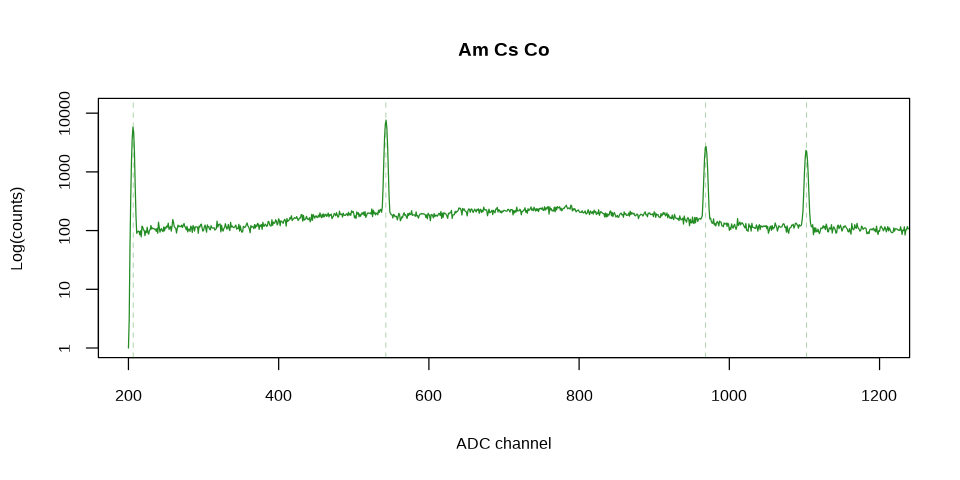

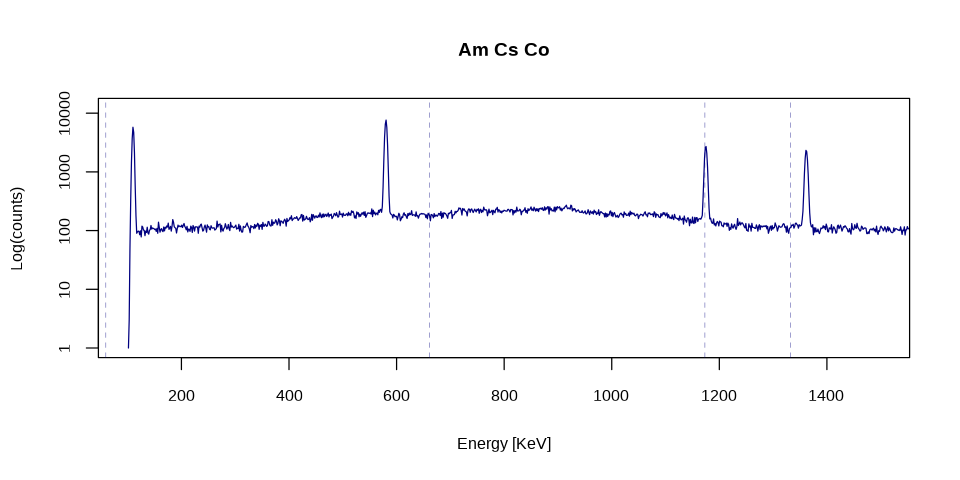

In [23]:
set_plot_dimensions(8, 4)

xmin <- 200;xmax<-1200
emin <- intercept + xmin*slope;  emax<- intercept + xmax*slope

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
abline(v=ACC_properties$x0_mean[1],col="forestgreen",lty=2,lwd=0.3)
abline(v=ACC_properties$x0_mean[2],col="forestgreen",lty=2,lwd=0.3)
abline(v=ACC_properties$x0_mean[3],col="forestgreen",lty=2,lwd=0.3)
abline(v=ACC_properties$x0_mean[4],col="forestgreen",lty=2,lwd=0.3)



plot(calibrated_energy,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
abline(v=df_ACC$ACC_energies[1],col="navy",lty=2,lwd=0.3)
abline(v=df_ACC$ACC_energies[2],col="navy",lty=2,lwd=0.3)
abline(v=df_ACC$ACC_energies[3],col="navy",lty=2,lwd=0.3)
abline(v=df_ACC$ACC_energies[4],col="navy",lty=2,lwd=0.3)

# Thallium

In [24]:
data_T <- read.table("data/IC48A_Th.txt", col.names = c('Ch', 'counts')) 

As we don't know which are the peaks to use we cheated, there is a paper from Baudis et.al https://arxiv.org/pdf/1508.05731.pdf with the spectrum from Th in a Germanium detector and there the peaks are identified so we picked two of them which were clearly the same as in our spectrum and used them to "calibrate the energy". We used this information to identify the peaks in our spectrum.

The 511 energy peak is between the channels 3150,3250 centered at 3215

The 2614 energy peak is between the channels 16200,16600 centered at 16450

As the lines we plotted clearly fit existing peaks, we trust that we are picking the correct ones. 

In [25]:
T_energies <-c(238.632,300.089,510.74,583.187,727.330,763.45,785.37,860.53,893.408,1078.63,1512.70,1592.511,1620.738,2103.511,2614.511)
df_T <- data.frame(T_energies)
row.names(df_T)<-c("Th 1","Th 2","Th 3","Th 4","Th 5","Th 6","Th 7", "Th 8", "Th 9", "Th 10", "Th 11",
                "Th 12", "Th 13", "Th 14", "Th 15")
df_T

,T_energies
Th 1,238.632
Th 2,300.089
Th 3,510.740
Th 4,583.187
Th 5,727.330
Th 6,763.450
Th 7,785.370
Th 8,860.530
Th 9,893.408
Th 10,1078.630


In [26]:
ch1<-3215;en1<-511
ch2<-16450;en2<-2614
b<-(ch1-ch2)/(en1-en2)
a<-ch1-en1*b
ch_th <- a+ df_T$T_energies *b

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

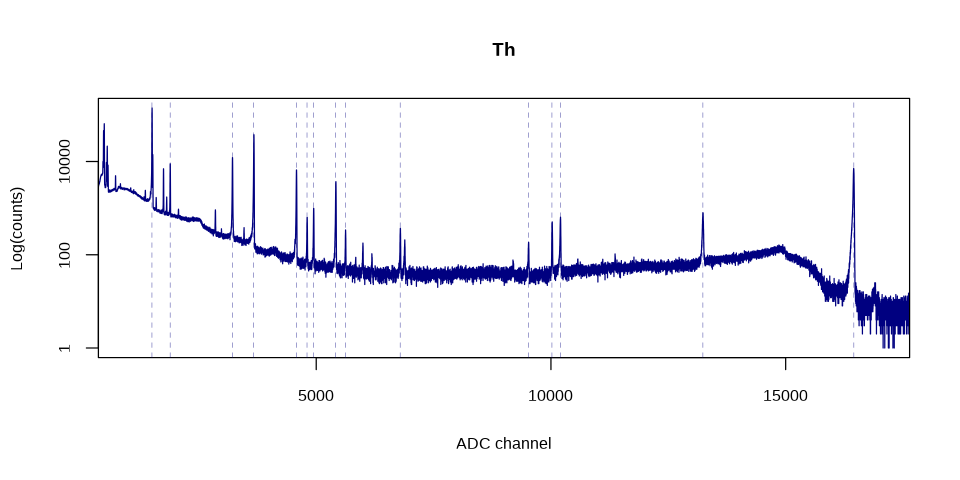

In [27]:
set_plot_dimensions(8, 4)

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
abline(v=ch_th[1],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[2],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[3],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[4],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[5],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[6],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[7],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[8],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[9],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[10],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[11],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[12],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[13],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[14],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[15],col="navy",lty=2,lwd=0.3)


In [28]:
th_1 <- NULL
th_1$x <- data_T$Ch[1450:1550]
th_1$y <- data_T$counts[1450:1550]

th_2 <- NULL
th_2$x <- data_T$Ch[1850:1950]
th_2$y <- data_T$counts[1850:1950]

th_3 <- NULL
th_3$x <- data_T$Ch[3100:3300]
th_3$y <- data_T$counts[3100:3300]

th_4 <- NULL
th_4$x <- data_T$Ch[3600:3750]
th_4$y <- data_T$counts[3600:3750]

th_5 <- NULL
th_5$x <- data_T$Ch[4500:4650]
th_5$y <- data_T$counts[4500:4650]

th_6 <- NULL
th_6$x <- data_T$Ch[4750:4850]
th_6$y <- data_T$counts[4750:4850]

th_7 <- NULL
th_7$x <- data_T$Ch[4900:5000]
th_7$y <- data_T$counts[4900:5000]

th_8 <- NULL
th_8$x <- data_T$Ch[5350:5475]
th_8$y <- data_T$counts[5350:5475]

th_9 <- NULL
th_9$x <- data_T$Ch[5600:5650]
th_9$y <- data_T$counts[5600:5650]

th_10 <- NULL
th_10$x <- data_T$Ch[6750:6850]
th_10$y <- data_T$counts[6750:6850]

th_11 <- NULL
th_11$x <- data_T$Ch[9500:9550]
th_11$y <- data_T$counts[9500:9550]

th_12 <- NULL
th_12$x <- data_T$Ch[10000:10060]
th_12$y <- data_T$counts[10000:10060]

th_13 <- NULL
th_13$x <- data_T$Ch[10150:10250]
th_13$y <- data_T$counts[10150:10250]

th_14 <- NULL
th_14$x <- data_T$Ch[13150:13300]
th_14$y <- data_T$counts[13150:13300]

th_15 <- NULL
th_15$x <- data_T$Ch[16200:16600]
th_15$y <- data_T$counts[16200:16600]


th_peaks <-list(th_1,th_2,th_3,th_4,th_5,th_6,th_7,th_8,th_9,th_10,th_11,th_12,th_13,th_14,th_15)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

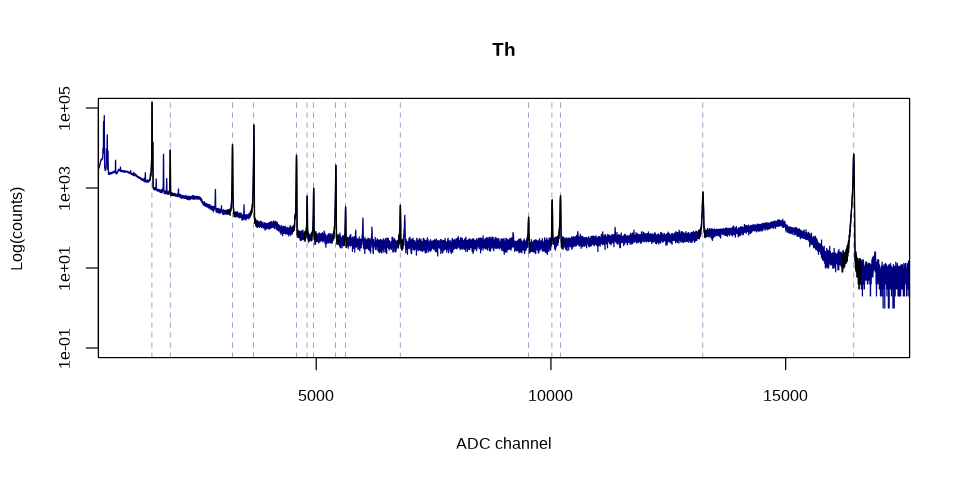

In [29]:
#Just to control we are picking the right ones
plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),ylim=c(1.e-1,1.e5),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
abline(v=ch_th[1],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[2],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[3],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[4],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[5],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[6],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[7],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[8],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[9],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[10],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[11],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[12],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[13],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[14],col="navy",lty=2,lwd=0.3)
abline(v=ch_th[15],col="navy",lty=2,lwd=0.3)

lines(th_1)
lines(th_2)
lines(th_3)
lines(th_4)
lines(th_5)
lines(th_6)
lines(th_7)
lines(th_8)
lines(th_9)
lines(th_10)
lines(th_11)
lines(th_12)
lines(th_13)
lines(th_14)
lines(th_15)

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  1.403e+05 0.143474 2.619e-03      2.628e-03
B  1.524e+03 0.313760 5.728e-03      5.729e-03
w  2.704e+00 0.001939 3.540e-05      3.471e-05
x0 1.503e+03 0.003011 5.497e-05      5.494e-05

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  1.403e+05 1.403e+05 1.403e+05 1.403e+05 1.403e+05
B  1.523e+03 1.524e+03 1.524e+03 1.524e+03 1.524e+03
w  2.701e+00 2.703e+00 2.704e+00 2.706e+00 2.708e+00
x0 1.503e+03 1.503e+03 1.503e+03 1.503e+03 1.503e+03



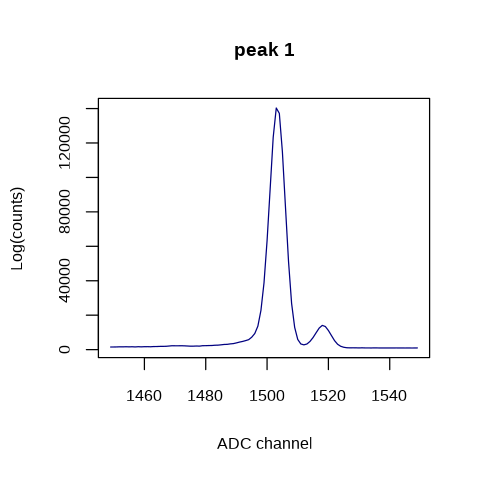

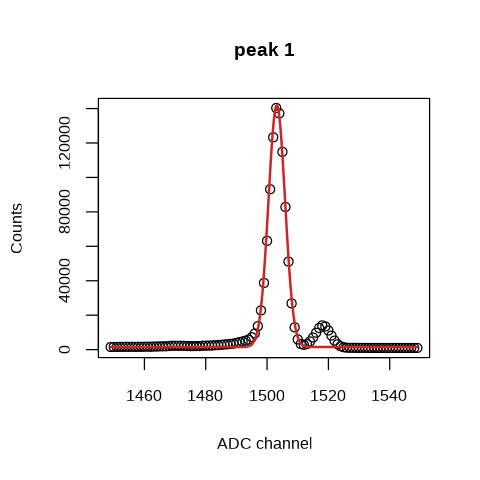

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  8897.992 0.137441 0.0025093      0.0027038
B   695.544 0.303542 0.0055419      0.0053254
w     2.756 0.009397 0.0001716      0.0001851
x0 1890.172 0.013881 0.0002534      0.0002534

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  8897.723 8897.899 8897.989 8898.082 8898.274
B   694.941  695.342  695.546  695.744  696.122
w     2.738    2.749    2.756    2.762    2.774
x0 1890.145 1890.163 1890.172 1890.182 1890.199



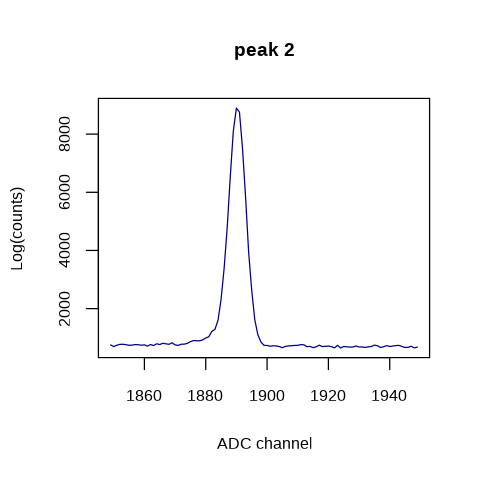

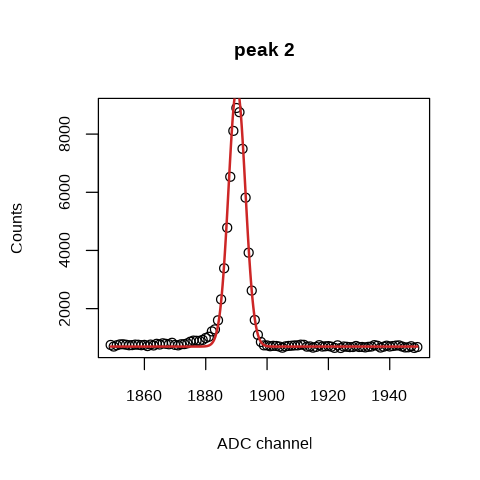

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  12094.983 0.141114 0.0025764      0.0025510
B    215.033 0.301935 0.0055126      0.0054183
w      4.098 0.008928 0.0001630      0.0001663
x0  3216.230 0.013445 0.0002455      0.0002556

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
A  12094.70 12094.886 12094.984 12095.077 12095.255
B    214.46   214.829   215.027   215.235   215.627
w      4.08     4.092     4.098     4.104     4.115
x0  3216.20  3216.221  3216.231  3216.239  3216.257



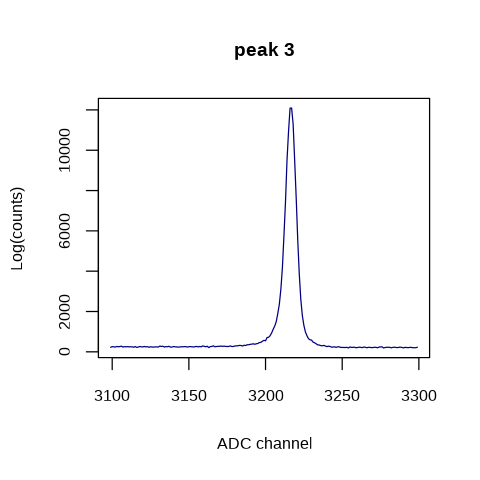

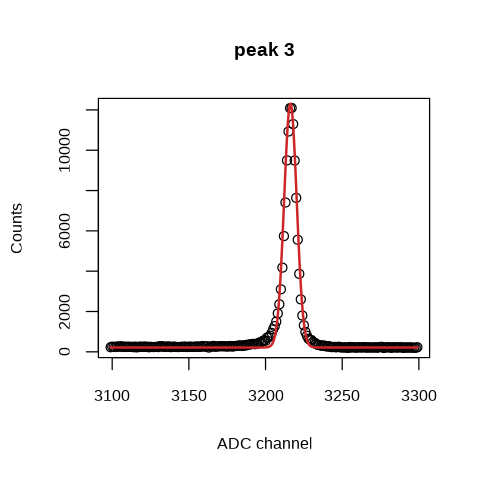

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  37494.993 0.141966 2.592e-03      2.593e-03
B    206.035 0.305983 5.586e-03      5.588e-03
w      3.929 0.004510 8.234e-05      8.378e-05
x0  3672.191 0.006952 1.269e-04      1.205e-04

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
A  37494.70 37494.897 37494.996 37495.092 37495.260
B    205.44   205.832   206.031   206.241   206.648
w      3.92     3.925     3.929     3.932     3.937
x0  3672.18  3672.186  3672.190  3672.195  3672.204



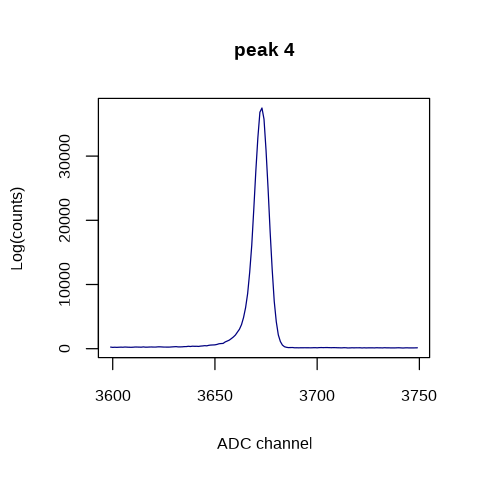

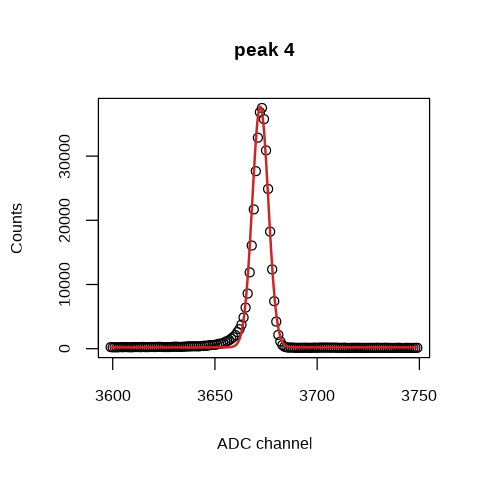

[1] "peak 5"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  6586.985 0.14070 0.0025689      0.0024489
B    84.724 0.29425 0.0053723      0.0051929
w     4.352 0.01155 0.0002109      0.0002109
x0 4579.221 0.01813 0.0003310      0.0003310

2. Quantiles for each variable:

      2.5%      25%      50%     75%    97.5%
A  6586.71 6586.891 6586.985 6587.08 6587.269
B    84.15   84.520   84.723   84.92   85.315
w     4.33    4.345    4.352    4.36    4.375
x0 4579.19 4579.209 4579.221 4579.23 4579.256



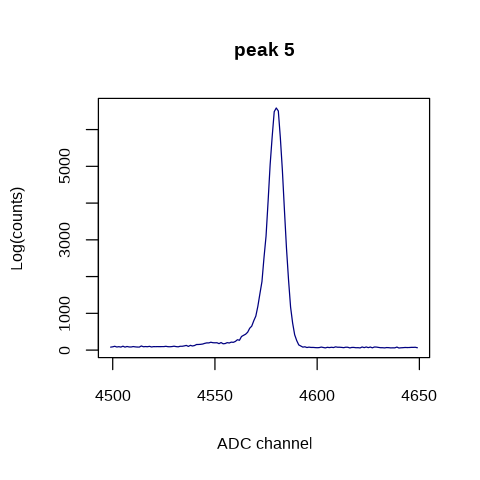

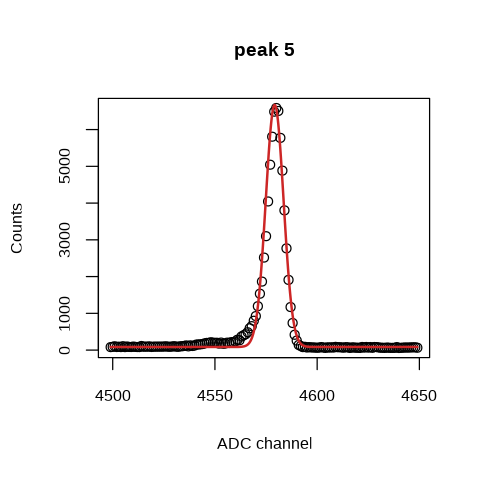

[1] "peak 6"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
A   629.98 0.13990 0.0025542      0.0025122
B    49.59 0.28791 0.0052564      0.0056013
w     4.45 0.04814 0.0008789      0.0008945
x0 4806.36 0.06835 0.0012479      0.0012483

2. Quantiles for each variable:

       2.5%      25%     50%      75%    97.5%
A   629.705  629.892  629.98  630.080  630.253
B    49.037   49.390   49.59   49.774   50.168
w     4.357    4.418    4.45    4.481    4.546
x0 4806.231 4806.317 4806.36 4806.411 4806.502



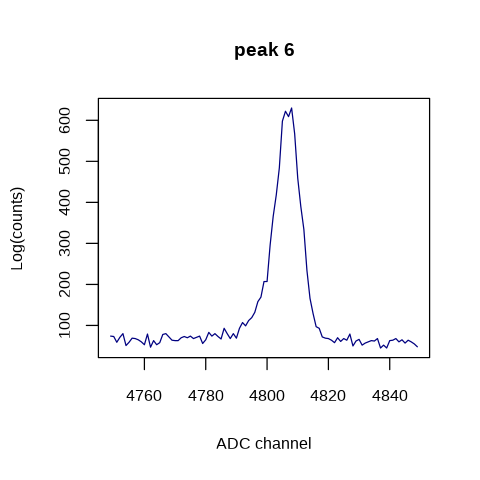

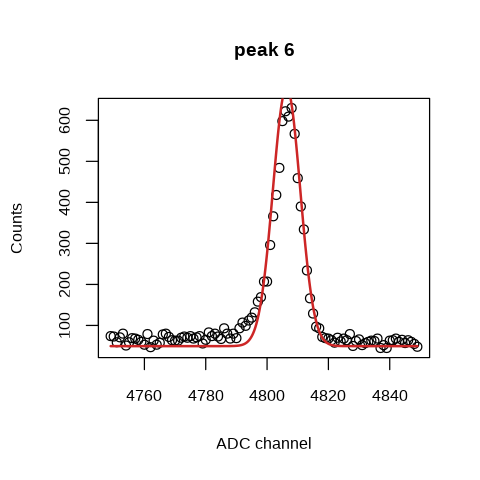

[1] "peak 7"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
A   989.99 0.13946 0.0025461      0.0026064
B    50.36 0.28675 0.0052352      0.0052350
w     4.45 0.03607 0.0006585      0.0006484
x0 4945.60 0.05062 0.0009242      0.0009244

2. Quantiles for each variable:

       2.5%      25%     50%      75%   97.5%
A   989.723  989.899  989.99  990.089  990.26
B    49.808   50.170   50.36   50.558   50.93
w     4.379    4.425    4.45    4.474    4.52
x0 4945.502 4945.566 4945.60 4945.633 4945.70



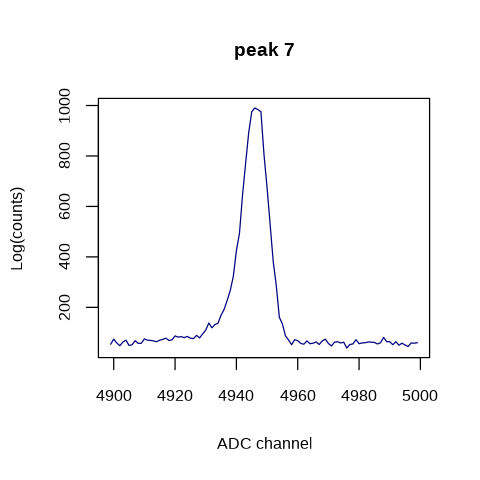

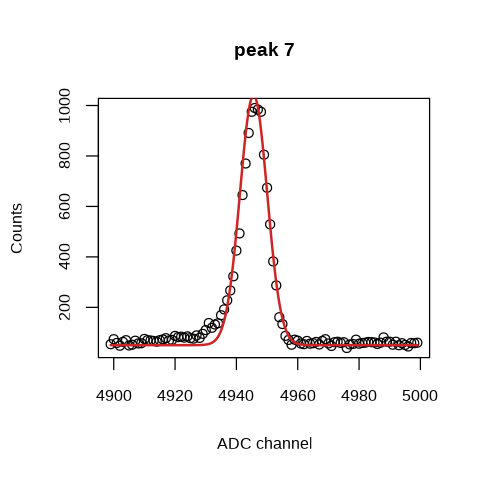

[1] "peak 8"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  3693.985 0.14100 0.0025743      0.0025996
B    52.859 0.27632 0.0050449      0.0050465
w     4.772 0.01693 0.0003090      0.0003154
x0 5417.789 0.02641 0.0004822      0.0004998

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  3693.701 3693.889 3693.984 3694.078 3694.260
B    52.329   52.671   52.858   53.046   53.394
w     4.739    4.761    4.772    4.783    4.805
x0 5417.737 5417.771 5417.789 5417.807 5417.839



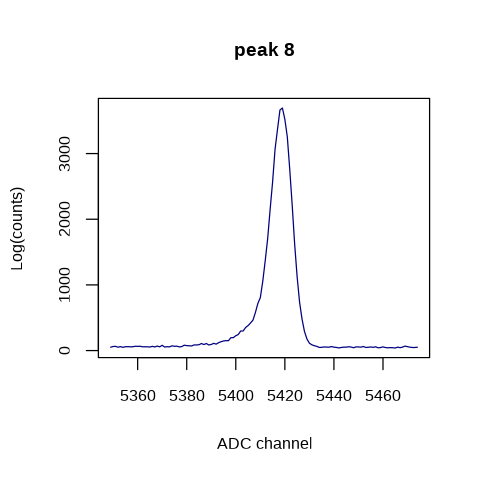

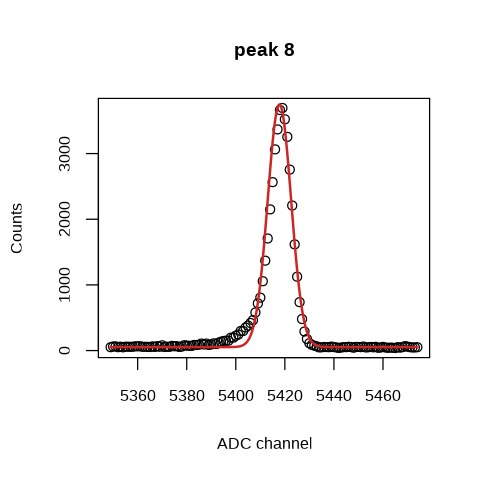

[1] "peak 9"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
A   339.974 0.14535 0.002654       0.002654
B    37.867 0.30656 0.005597       0.005613
w     4.447 0.07276 0.001328       0.001285
x0 5625.066 0.10300 0.001881       0.001742

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A   339.695  339.875  339.974  340.073  340.266
B    37.271   37.664   37.862   38.075   38.485
w     4.308    4.398    4.446    4.498    4.587
x0 5624.872 5624.995 5625.062 5625.136 5625.272



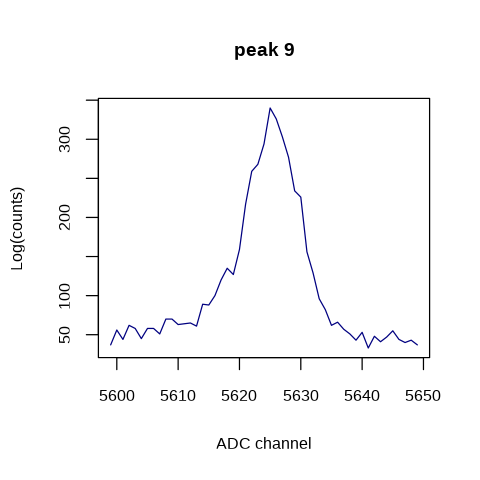

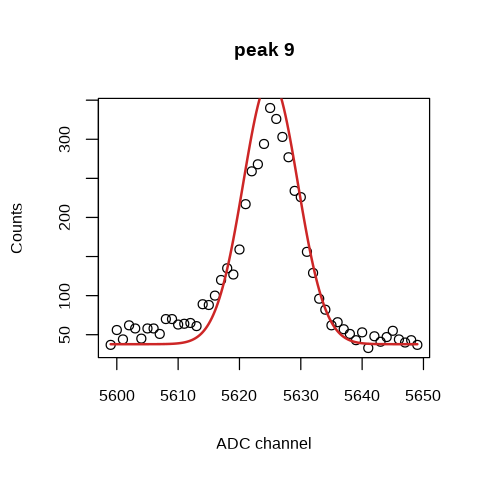

[1] "peak 10"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
A   368.976 0.14189 0.002591       0.002545
B    34.954 0.28186 0.005146       0.005038
w     4.911 0.06907 0.001261       0.001260
x0 6791.421 0.09874 0.001803       0.001799

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A   368.696  368.880  368.977  369.073  369.247
B    34.411   34.767   34.949   35.137   35.530
w     4.779    4.863    4.911    4.957    5.049
x0 6791.224 6791.354 6791.421 6791.489 6791.612



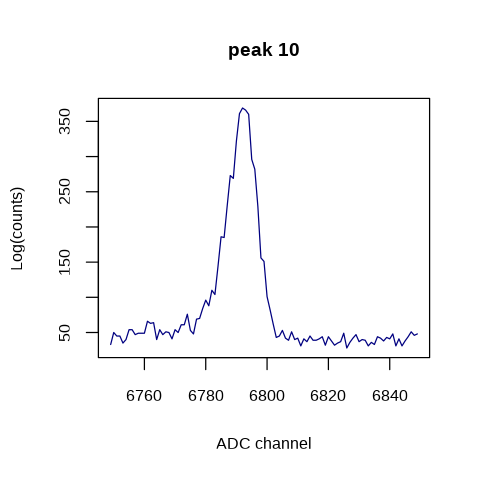

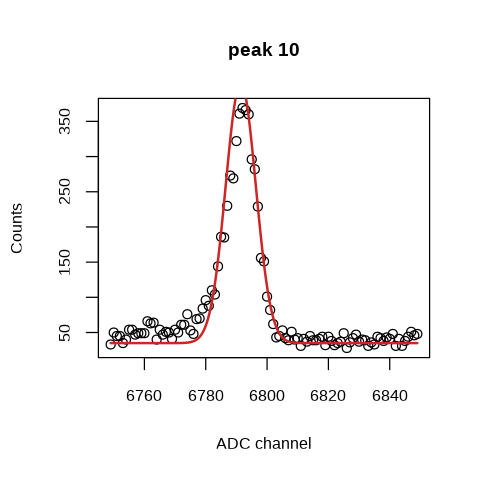

[1] "peak 11"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD Naive SE Time-series SE
A   185.964 0.1394 0.002544       0.002552
B    34.518 0.3067 0.005599       0.005729
w     5.466 0.1289 0.002353       0.002362
x0 9523.178 0.1742 0.003180       0.003107

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A   185.686  185.874  185.962  186.055  186.244
B    33.941   34.305   34.513   34.733   35.110
w     5.221    5.375    5.466    5.554    5.718
x0 9522.841 9523.057 9523.176 9523.297 9523.526



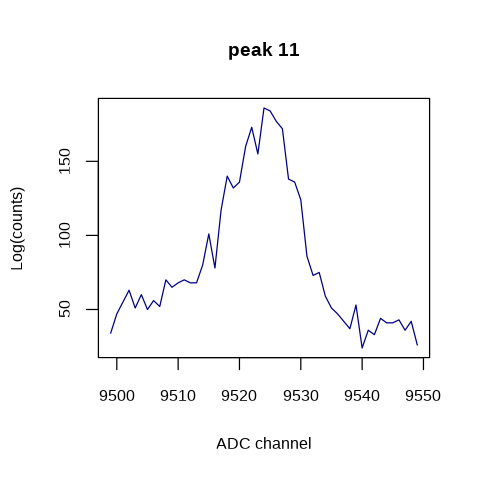

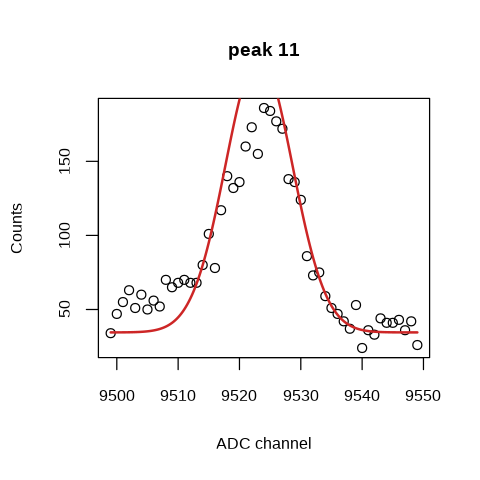

[1] "peak 12"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
A    505.981 0.13938 0.0025447      0.0025453
B     40.470 0.31504 0.0057518      0.0057536
w      5.131 0.05348 0.0009765      0.0009653
x0 10025.994 0.08111 0.0014809      0.0015442

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
A    505.71   505.888   505.982   506.075   506.260
B     39.86    40.259    40.473    40.677    41.086
w      5.03     5.094     5.131     5.169     5.236
x0 10025.83 10025.940 10025.994 10026.051 10026.155



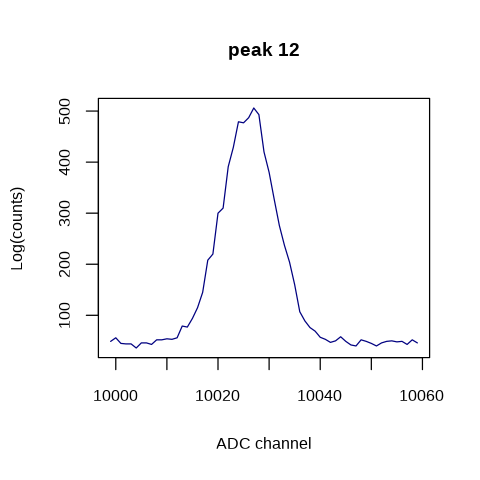

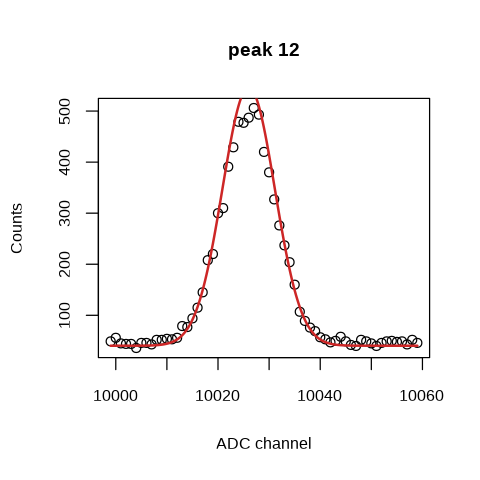

[1] "peak 13"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
A    638.97 0.14041 0.002563       0.002564
B     45.60 0.29487 0.005383       0.005287
w      6.06 0.05507 0.001005       0.001006
x0 10201.76 0.08139 0.001486       0.001486

2. Quantiles for each variable:

        2.5%       25%      50%       75%     97.5%
A    638.707   638.874   638.97   639.070   639.250
B     45.033    45.395    45.59    45.788    46.176
w      5.954     6.021     6.06     6.096     6.167
x0 10201.596 10201.703 10201.76 10201.815 10201.919



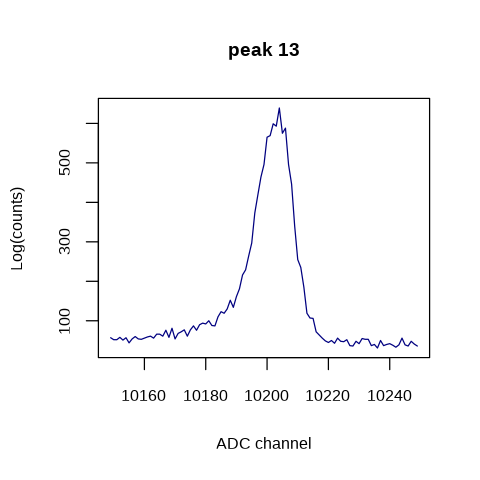

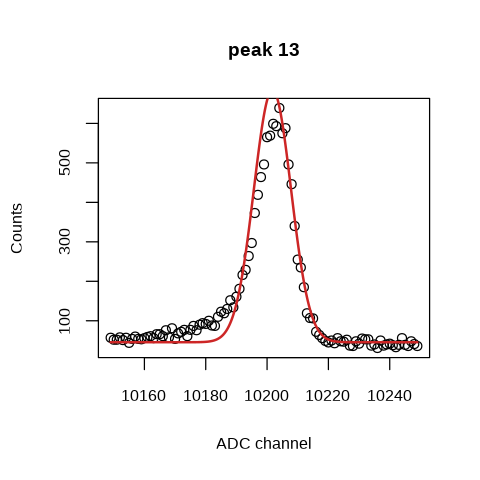

[1] "peak 14"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD Naive SE Time-series SE
A    796.940 0.14247 0.002601       0.002458
B     60.777 0.28518 0.005207       0.004894
w      9.861 0.06219 0.001135       0.001159
x0 13236.794 0.09562 0.001746       0.001770

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A    796.667   796.842   796.938   797.036   797.219
B     60.231    60.585    60.777    60.962    61.333
w      9.731     9.819     9.863     9.905     9.976
x0 13236.610 13236.730 13236.793 13236.857 13236.984



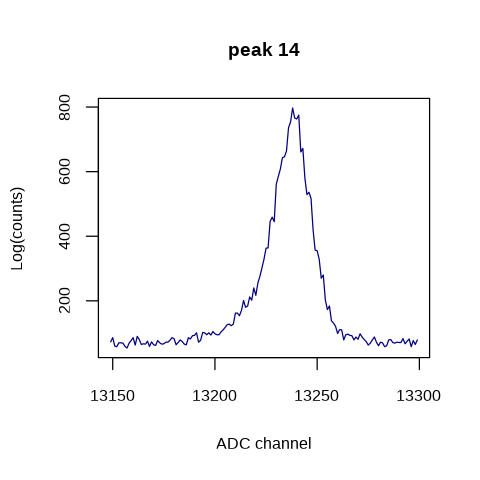

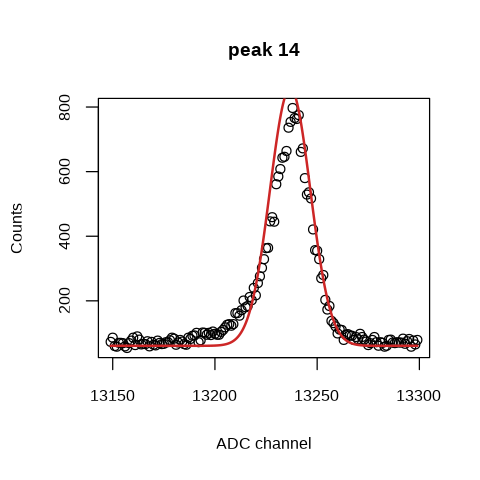

[1] "peak 15"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
A   7084.946 0.14188 0.0025904      0.0024840
B     29.523 0.19760 0.0036077      0.0036443
w      9.351 0.01730 0.0003159      0.0003279
x0 16446.596 0.02668 0.0004872      0.0004683

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A   7084.671  7084.849  7084.946  7085.040  7085.226
B     29.127    29.394    29.523    29.662    29.894
w      9.317     9.339     9.351     9.362     9.384
x0 16446.545 16446.578 16446.595 16446.614 16446.650



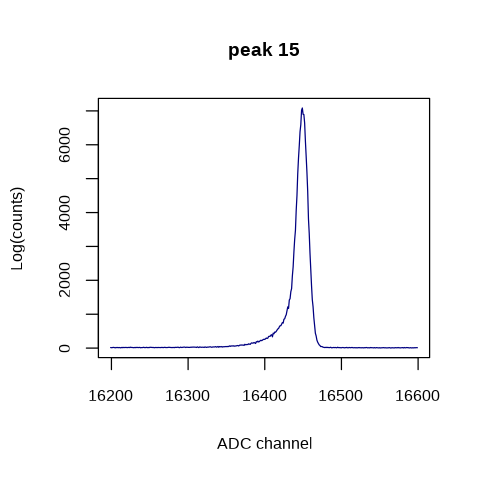

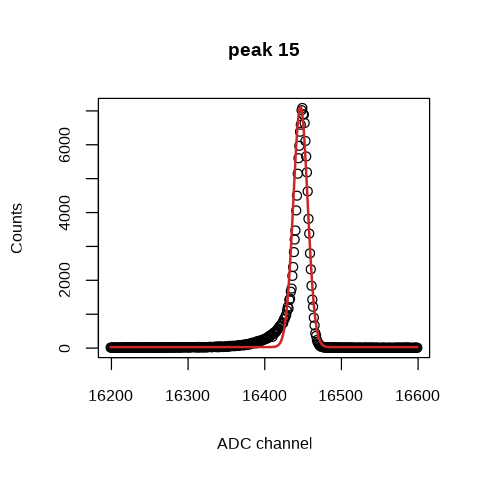

In [30]:
T_properties <- peak_properties(th_peaks)

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  1.403e+05 0.143474 2.619e-03      2.628e-03
B  1.524e+03 0.313760 5.728e-03      5.729e-03
w  2.704e+00 0.001939 3.540e-05      3.471e-05
x0 1.503e+03 0.003011 5.497e-05      5.494e-05

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  1.403e+05 1.403e+05 1.403e+05 1.403e+05 1.403e+05
B  1.523e+03 1.524e+03 1.524e+03 1.524e+03 1.524e+03
w  2.701e+00 2.703e+00 2.704e+00 2.706e+00 2.708e+00
x0 1.503e+03 1.503e+03 1.503e+03 1.503e+03 1.503e+03



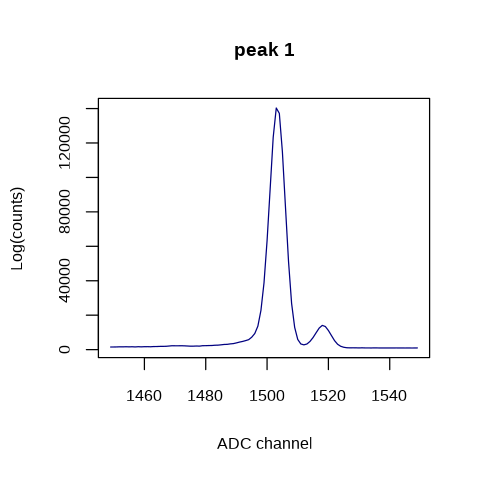

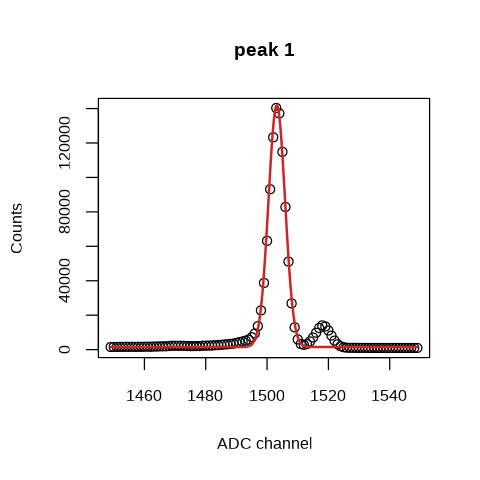

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  8897.992 0.137441 0.0025093      0.0027038
B   695.544 0.303542 0.0055419      0.0053254
w     2.756 0.009397 0.0001716      0.0001851
x0 1890.172 0.013881 0.0002534      0.0002534

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  8897.723 8897.899 8897.989 8898.082 8898.274
B   694.941  695.342  695.546  695.744  696.122
w     2.738    2.749    2.756    2.762    2.774
x0 1890.145 1890.163 1890.172 1890.182 1890.199



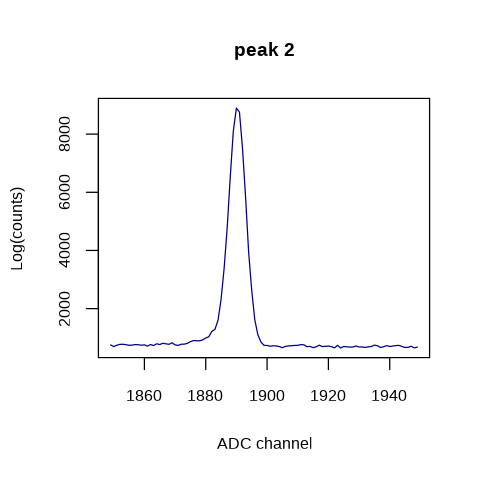

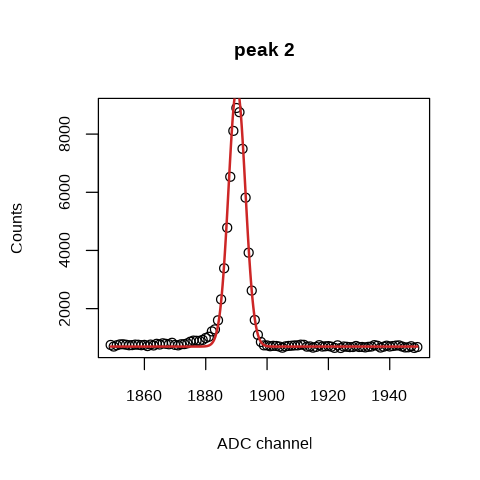

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  12094.983 0.141114 0.0025764      0.0025510
B    215.033 0.301935 0.0055126      0.0054183
w      4.098 0.008928 0.0001630      0.0001663
x0  3216.230 0.013445 0.0002455      0.0002556

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
A  12094.70 12094.886 12094.984 12095.077 12095.255
B    214.46   214.829   215.027   215.235   215.627
w      4.08     4.092     4.098     4.104     4.115
x0  3216.20  3216.221  3216.231  3216.239  3216.257



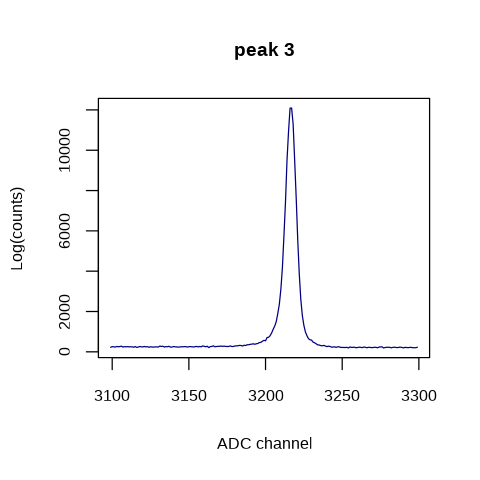

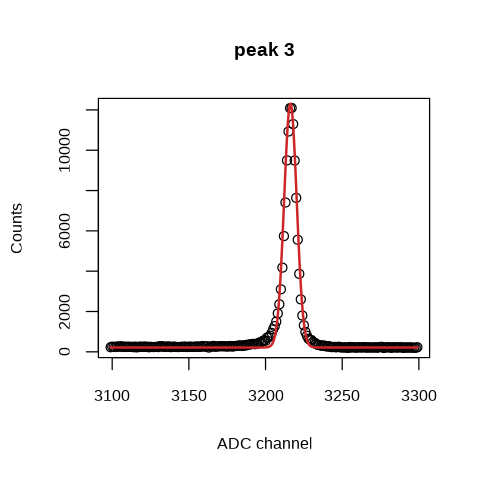

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  37494.993 0.141966 2.592e-03      2.593e-03
B    206.035 0.305983 5.586e-03      5.588e-03
w      3.929 0.004510 8.234e-05      8.378e-05
x0  3672.191 0.006952 1.269e-04      1.205e-04

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
A  37494.70 37494.897 37494.996 37495.092 37495.260
B    205.44   205.832   206.031   206.241   206.648
w      3.92     3.925     3.929     3.932     3.937
x0  3672.18  3672.186  3672.190  3672.195  3672.204



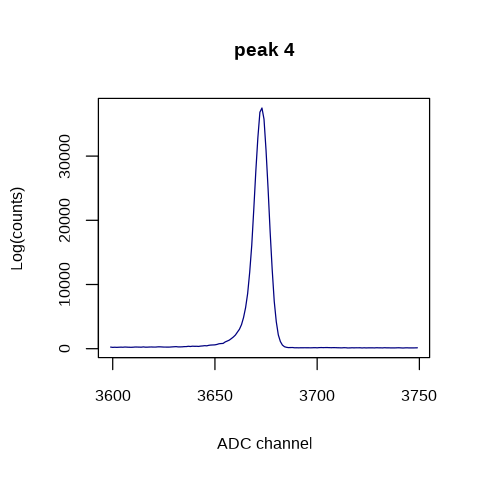

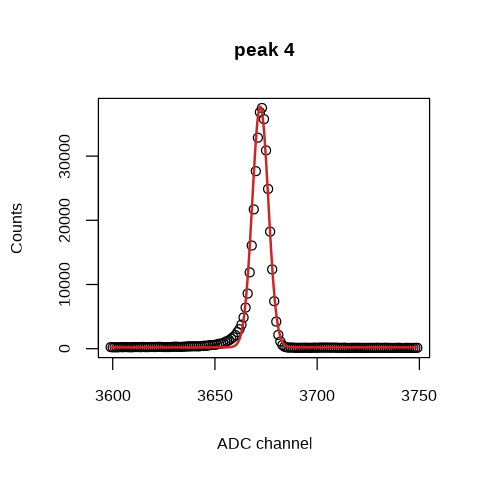

[1] "peak 5"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  6586.985 0.14070 0.0025689      0.0024489
B    84.724 0.29425 0.0053723      0.0051929
w     4.352 0.01155 0.0002109      0.0002109
x0 4579.221 0.01813 0.0003310      0.0003310

2. Quantiles for each variable:

      2.5%      25%      50%     75%    97.5%
A  6586.71 6586.891 6586.985 6587.08 6587.269
B    84.15   84.520   84.723   84.92   85.315
w     4.33    4.345    4.352    4.36    4.375
x0 4579.19 4579.209 4579.221 4579.23 4579.256



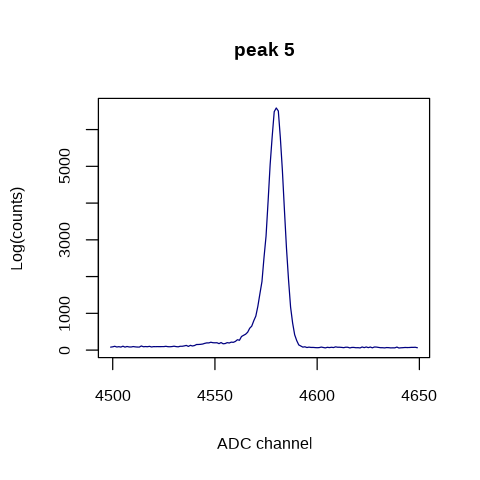

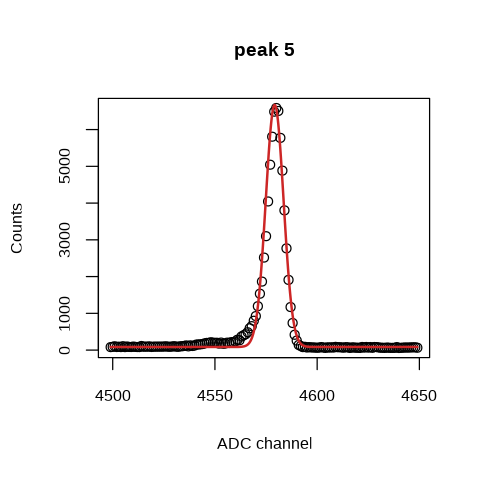

[1] "peak 6"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
A   629.98 0.13990 0.0025542      0.0025122
B    49.59 0.28791 0.0052564      0.0056013
w     4.45 0.04814 0.0008789      0.0008945
x0 4806.36 0.06835 0.0012479      0.0012483

2. Quantiles for each variable:

       2.5%      25%     50%      75%    97.5%
A   629.705  629.892  629.98  630.080  630.253
B    49.037   49.390   49.59   49.774   50.168
w     4.357    4.418    4.45    4.481    4.546
x0 4806.231 4806.317 4806.36 4806.411 4806.502



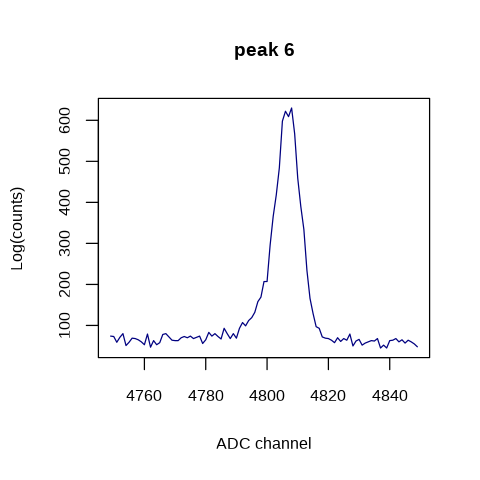

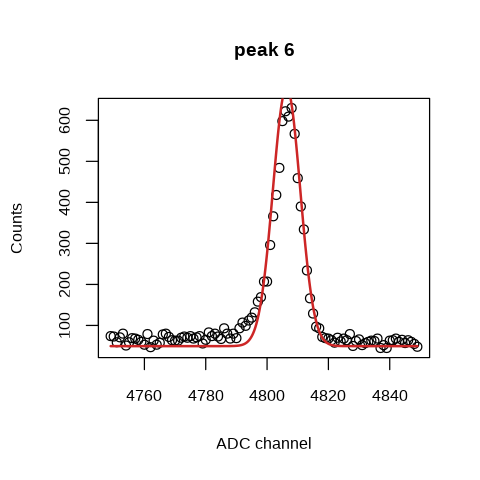

[1] "peak 7"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
A   989.99 0.13946 0.0025461      0.0026064
B    50.36 0.28675 0.0052352      0.0052350
w     4.45 0.03607 0.0006585      0.0006484
x0 4945.60 0.05062 0.0009242      0.0009244

2. Quantiles for each variable:

       2.5%      25%     50%      75%   97.5%
A   989.723  989.899  989.99  990.089  990.26
B    49.808   50.170   50.36   50.558   50.93
w     4.379    4.425    4.45    4.474    4.52
x0 4945.502 4945.566 4945.60 4945.633 4945.70



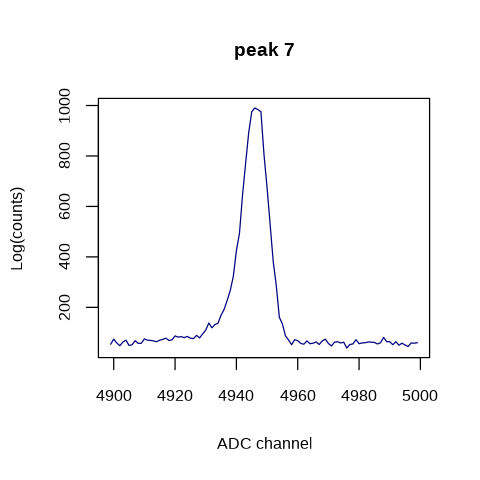

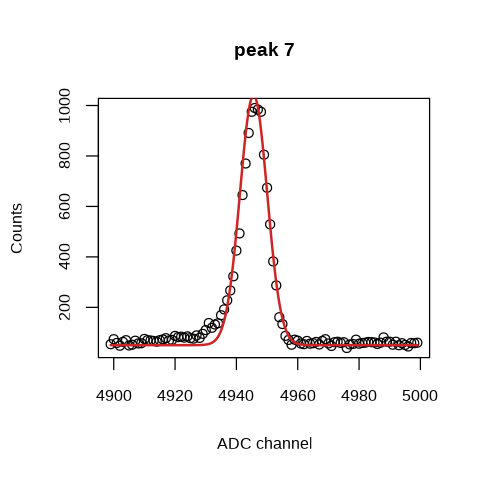

[1] "peak 8"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  3693.985 0.14100 0.0025743      0.0025996
B    52.859 0.27632 0.0050449      0.0050465
w     4.772 0.01693 0.0003090      0.0003154
x0 5417.789 0.02641 0.0004822      0.0004998

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  3693.701 3693.889 3693.984 3694.078 3694.260
B    52.329   52.671   52.858   53.046   53.394
w     4.739    4.761    4.772    4.783    4.805
x0 5417.737 5417.771 5417.789 5417.807 5417.839



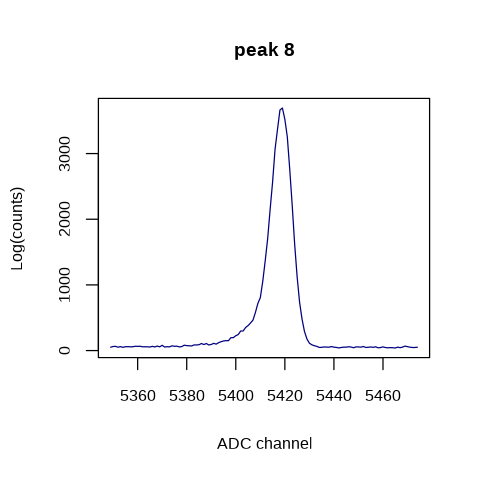

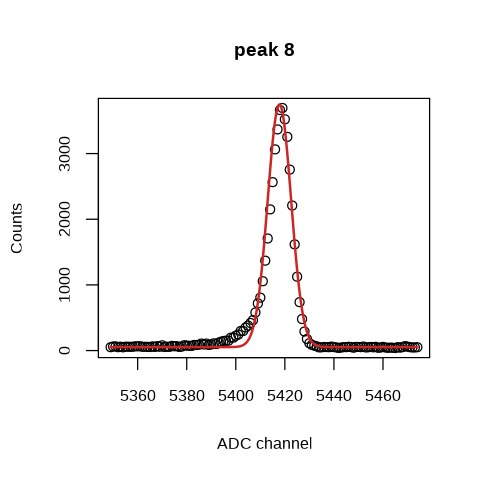

[1] "peak 9"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
A   339.974 0.14535 0.002654       0.002654
B    37.867 0.30656 0.005597       0.005613
w     4.447 0.07276 0.001328       0.001285
x0 5625.066 0.10300 0.001881       0.001742

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A   339.695  339.875  339.974  340.073  340.266
B    37.271   37.664   37.862   38.075   38.485
w     4.308    4.398    4.446    4.498    4.587
x0 5624.872 5624.995 5625.062 5625.136 5625.272



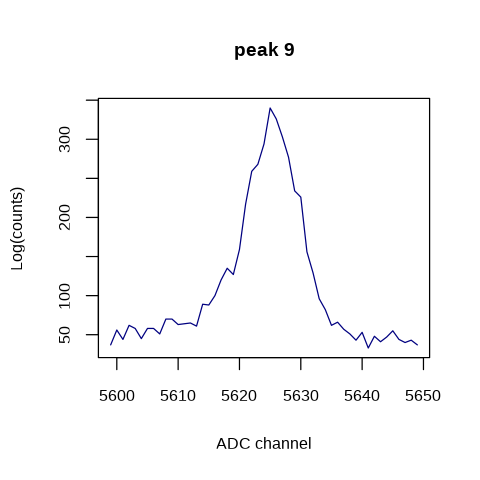

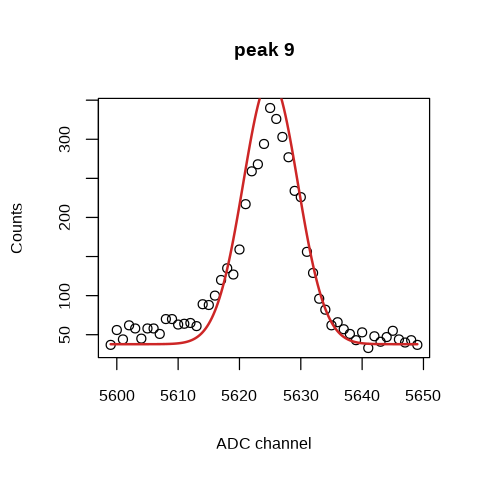

[1] "peak 10"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
A   368.976 0.14189 0.002591       0.002545
B    34.954 0.28186 0.005146       0.005038
w     4.911 0.06907 0.001261       0.001260
x0 6791.421 0.09874 0.001803       0.001799

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A   368.696  368.880  368.977  369.073  369.247
B    34.411   34.767   34.949   35.137   35.530
w     4.779    4.863    4.911    4.957    5.049
x0 6791.224 6791.354 6791.421 6791.489 6791.612



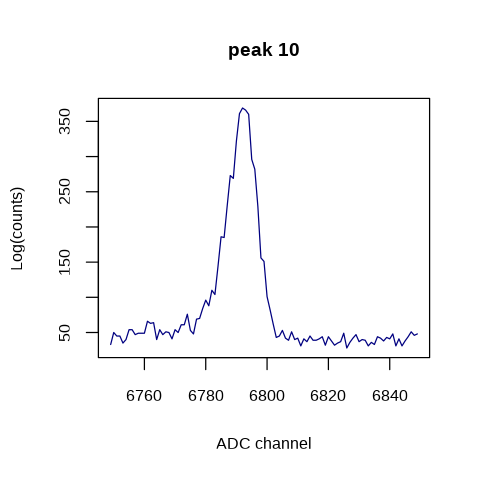

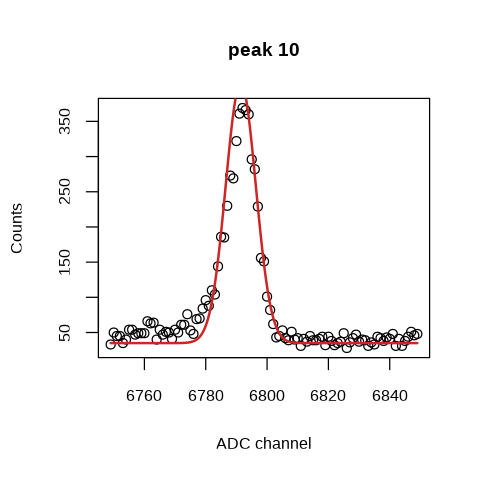

[1] "peak 11"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD Naive SE Time-series SE
A   185.964 0.1394 0.002544       0.002552
B    34.518 0.3067 0.005599       0.005729
w     5.466 0.1289 0.002353       0.002362
x0 9523.178 0.1742 0.003180       0.003107

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A   185.686  185.874  185.962  186.055  186.244
B    33.941   34.305   34.513   34.733   35.110
w     5.221    5.375    5.466    5.554    5.718
x0 9522.841 9523.057 9523.176 9523.297 9523.526



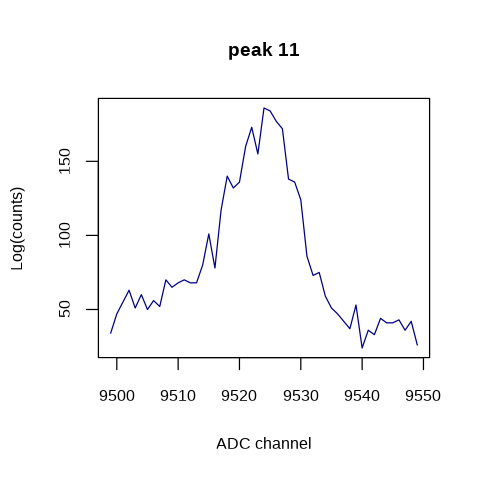

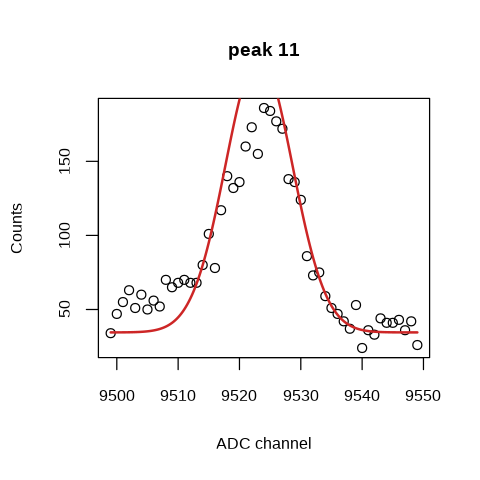

[1] "peak 12"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
A    505.981 0.13938 0.0025447      0.0025453
B     40.470 0.31504 0.0057518      0.0057536
w      5.131 0.05348 0.0009765      0.0009653
x0 10025.994 0.08111 0.0014809      0.0015442

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
A    505.71   505.888   505.982   506.075   506.260
B     39.86    40.259    40.473    40.677    41.086
w      5.03     5.094     5.131     5.169     5.236
x0 10025.83 10025.940 10025.994 10026.051 10026.155



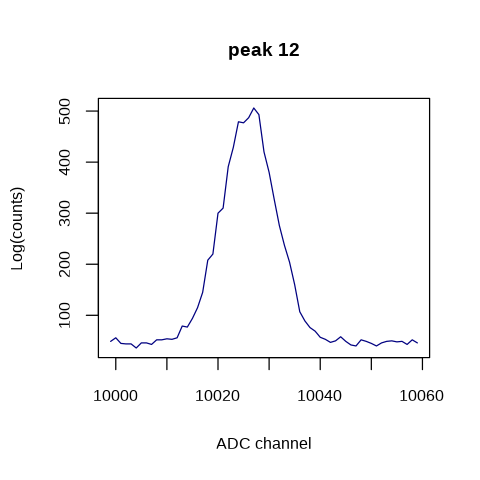

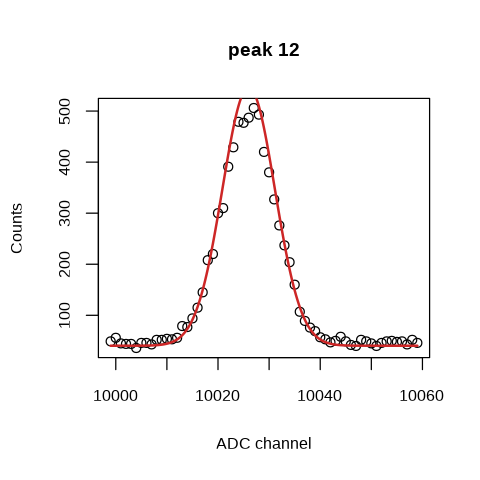

[1] "peak 13"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
A    638.97 0.14041 0.002563       0.002564
B     45.60 0.29487 0.005383       0.005287
w      6.06 0.05507 0.001005       0.001006
x0 10201.76 0.08139 0.001486       0.001486

2. Quantiles for each variable:

        2.5%       25%      50%       75%     97.5%
A    638.707   638.874   638.97   639.070   639.250
B     45.033    45.395    45.59    45.788    46.176
w      5.954     6.021     6.06     6.096     6.167
x0 10201.596 10201.703 10201.76 10201.815 10201.919



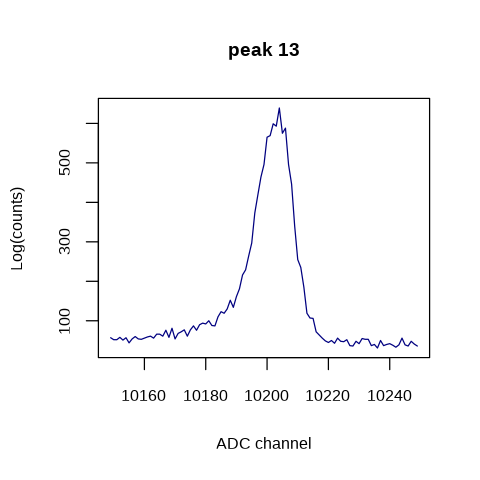

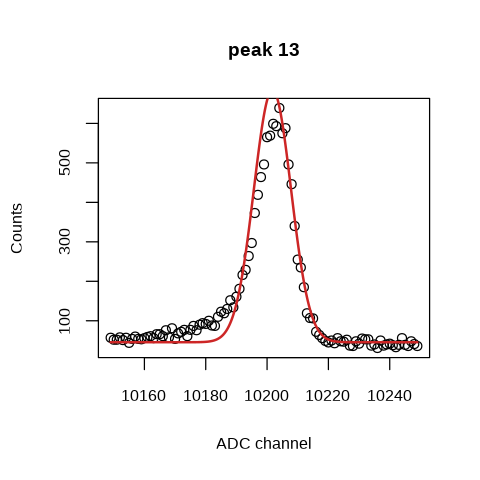

[1] "peak 14"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD Naive SE Time-series SE
A    796.940 0.14247 0.002601       0.002458
B     60.777 0.28518 0.005207       0.004894
w      9.861 0.06219 0.001135       0.001159
x0 13236.794 0.09562 0.001746       0.001770

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A    796.667   796.842   796.938   797.036   797.219
B     60.231    60.585    60.777    60.962    61.333
w      9.731     9.819     9.863     9.905     9.976
x0 13236.610 13236.730 13236.793 13236.857 13236.984



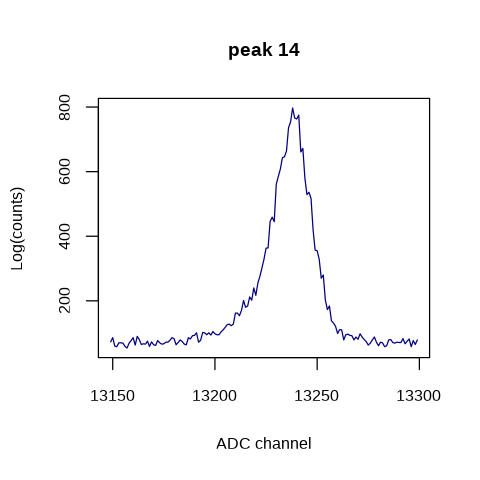

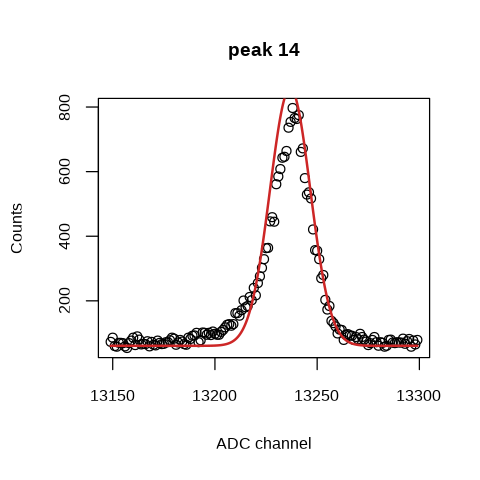

[1] "peak 15"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
A   7084.946 0.14188 0.0025904      0.0024840
B     29.523 0.19760 0.0036077      0.0036443
w      9.351 0.01730 0.0003159      0.0003279
x0 16446.596 0.02668 0.0004872      0.0004683

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A   7084.671  7084.849  7084.946  7085.040  7085.226
B     29.127    29.394    29.523    29.662    29.894
w      9.317     9.339     9.351     9.362     9.384
x0 16446.545 16446.578 16446.595 16446.614 16446.650



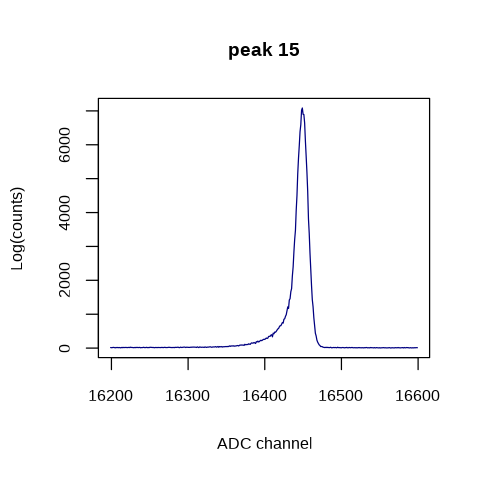

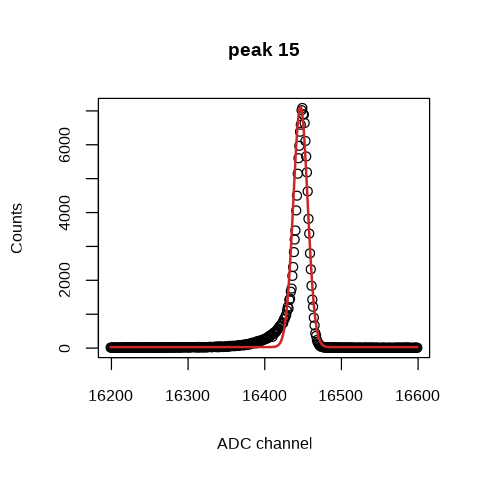

In [31]:
i=1
chains <-c()
x0_mean <-c()
x0_std <-c()
w_mean <-c()
w_std <-c()

for (pk in th_peaks){

#Plot of the choosen peak
set_plot_dimensions(4, 4)
plot(pk$x,pk$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel",
    main=paste("peak",i))

A.min <- min(pk$y)
A.max <- max(pk$y)
B.min <- 0
B.max <- max(c(min(pk$y[1:floor(length(pk$y)/2)]),min(pk$y[floor(length(pk$y)/2):length(pk$y)])))  #This is a critical point for peaks that doesn't have a
                     #a stable noise around so min(pk$y) is not representative
x0.min <- min(pk$x)  
x0.max <- max(pk$x)

cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dnorm(",A.max,",",50,")
    B ~ dnorm(",B.max,",",10,")

    x0 ~ dunif(",x0.min,",",x0.max,")
    w ~ dunif(1,10)
      
}", file=paste("Models/model_peak_",i,".bug",sep=""))

model <- paste("Models/model_peak_",i,".bug",sep="")


#If multiple chains are run, each of them need to be initialized
init <- NULL;init$A  <- (A.max-A.min)/2
init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

#To have absolute control we also set the seed for and random number generator for each chain
init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10


jm <- jags.model(model,
                 pk,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
chains <- append(chains,list(chain))

#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
#plot(chain)
print(paste("peak",i))
print(summary(chain))

A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x0_mean <- c(x0_mean,x0)
x0_std  <- c(x0_std,summary(chain)$statistics[4,2])
w_mean <- c(w_mean,w)
w_std  <- c(w_std,summary(chain)$statistics[3,2])
    
x <- seq(x0.min,x0.max,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


set_plot_dimensions(4, 4)
plot(pk$x,pk$y,
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')
i=i+1
}

### Energy calibration

In [32]:
df_T$x0_mean <- T_properties$x0_mean
df_T$x0_std  <- T_properties$x0_std
df_T$w_mean  <- T_properties$w_mean
df_T$w_std   <- T_properties$w_std


#df <- data.frame(energy_th,x0_mean,x0_std)
#row.names(df)<-c("Th 1","Th 2","Th 3","Th 4","Th 5","Th 6","Th 7", "Th 8", "Th 9", "Th 10", "Th 11",
#                "Th 12", "Th 13", "Th 14", "Th 15")

In [33]:
df_T

,T_energies,x0_mean,x0_std,w_mean,w_std
Th 1,238.632,1503.164,0.003010777,2.704313,0.001938908
Th 2,300.089,1890.172,0.013881068,2.755689,0.009396985
Th 3,510.740,3216.230,0.013444651,4.097722,0.008928485
Th 4,583.187,3672.191,0.006952109,3.928637,0.004509703
Th 5,727.330,4579.221,0.018132064,4.352159,0.011551840
Th 6,763.450,4806.365,0.068349125,4.450150,0.048137411
Th 7,785.370,4945.600,0.050619819,4.449739,0.036067610
Th 8,860.530,5417.789,0.026413684,4.771975,0.016926113
Th 9,893.408,5625.066,0.103002756,4.446919,0.072757402
Th 10,1078.630,6791.421,0.098735444,4.910911,0.069074900


In [34]:
linear_fit <- lm( df_T$T_energies ~ df_T$x0_mean )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
calibrated_energy <- intercept + data_T$Ch*slope

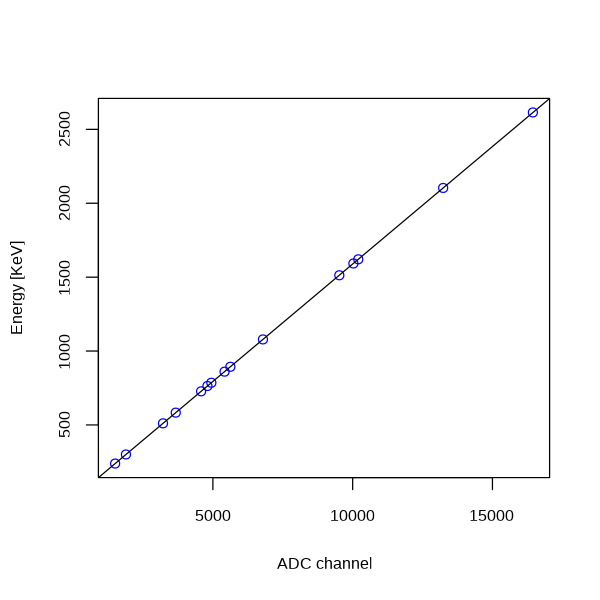

In [35]:
set_plot_dimensions(5, 5)
plot(df_T$x0_mean,df_T$T_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="")
lines(data_T$Ch,calibrated_energy)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

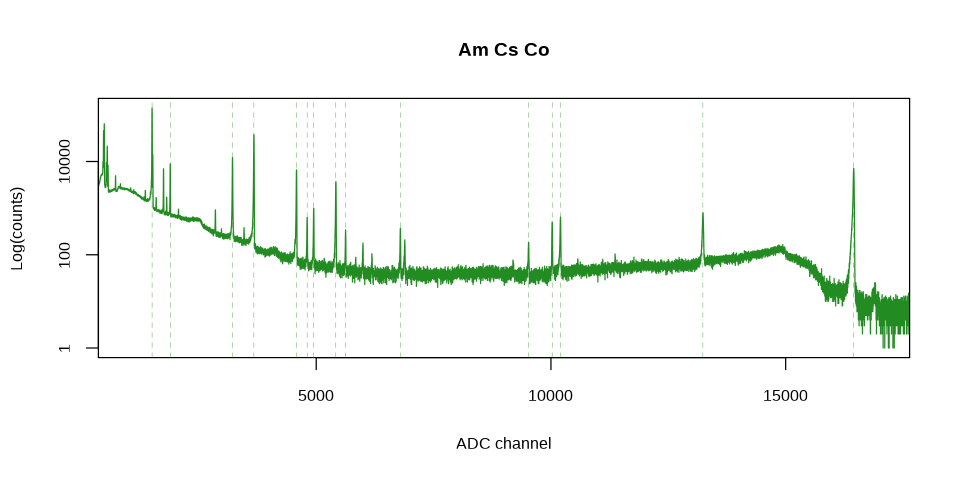

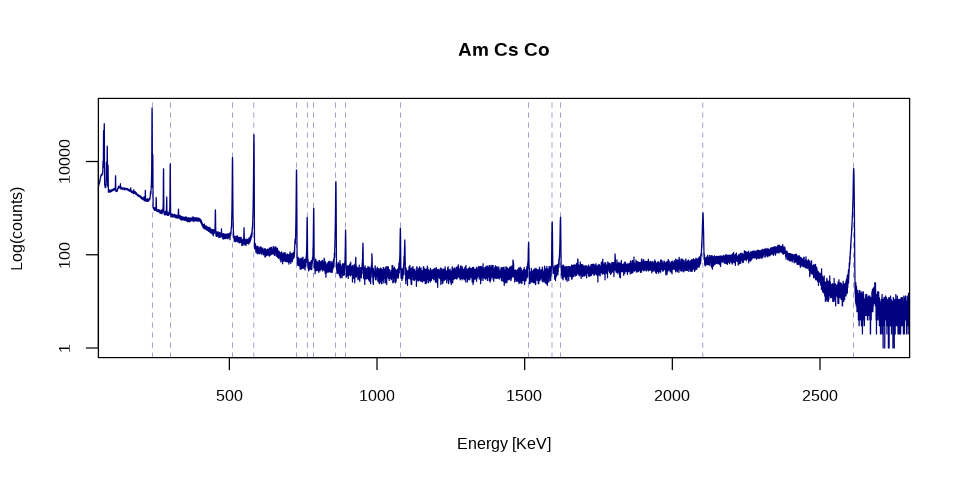

In [36]:
set_plot_dimensions(8, 4)

xmin<-1000;xmax<-17000
emin<-intercept + xmin*slope; emax<- intercept + xmax*slope

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
abline(v=df_T$x0_mean[1],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[2],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[3],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[4],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[5],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[6],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[7],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[8],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[9],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[10],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[11],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[12],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[13],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[14],col="forestgreen",lty=2,lwd=0.3)
abline(v=df_T$x0_mean[15],col="forestgreen",lty=2,lwd=0.3)


plot(calibrated_energy,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
abline(v=df_T$T_energies[1],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[2],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[3],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[4],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[5],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[6],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[7],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[8],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[9],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[10],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[11],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[12],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[13],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[14],col="navy",lty=2,lwd=0.3)
abline(v=df_T$T_energies[15],col="navy",lty=2,lwd=0.3)

## Resolution study

In [37]:
df$FWHM_mean <- 2*sqrt(2*log(2))*w_mean
#df$FWHM_std <- w_std

ERROR: Error in df$FWHM_mean <- 2 * sqrt(2 * log(2)) * w_mean: object of type 'closure' is not subsettable


In [ ]:
df

In [ ]:
set_plot_dimensions(5, 5)
plot(df$energy_th,df$FWHM_mean,col="blue",
    xlab="Energy [KeV]",ylab="FWHM",
    main="")


In [ ]:
dt <- NULL
dt$x <- df$energy_th
dt$y <- df$FWHM_mean

In [ ]:
cat("model{

    #The likelihood:
    F = 0.113 #Fano factor
    
    for (i in 1:length(x)){
        f[i] <- sqrt(4*2*log(2) * F *x[i] * w + we**2);  
        
        y[i] ~ dnorm(f[i],0.5);
 
    } 


    # Priors for  

    w ~ dunif(1.e-3,5.e-3);
    we ~ dnorm(3,0.25);
    #sigma ~ dnorm(0,1);

      
}", file="Models/fwhm.bug")
model <- "Models/fwhm.bug"

In [ ]:
init <- NULL
init$w   <- 3.e-3
init$we  <- 3;   init$sigma  <- 0.1
init <- c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill")

In [ ]:
chain_number <- 1
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10

In [ ]:
jm <- jags.model(model,
                 dt,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

update(jm, burnin)


In [ ]:
chain <- coda.samples(jm, c("w","we","sigma"), n.iter=iterations,thin=thining)

In [ ]:
summary(chain)

In [ ]:
set_plot_dimensions(8, 8)
plot(chain)

In [ ]:
w  <- summary(chain)$statistics[2]
we  <- summary(chain)$statistics[3]


In [ ]:
fano <-0.115
    
x <- seq(100,1400,1)
f <- sqrt(4*2*log(2) * fano * x * w + we**2)
#f <- sqrt(a * x  + b**2)

set_plot_dimensions(4, 4)
plot(df$energy_th,df$FWHM_mean,#xlim=c(0,1400),ylim=c(1.4,3.8),
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')

plot(x,f,type="l",xlim=c(0,1400))

In [ ]:
a <-(y1**2-y2**2)/(x1-x2)
a
b<- sqrt(y1**2-a*x1)
b

In [ ]:
#install.packages("robustbase")
library(robustbase)

In [ ]:
f <- function(x, w,we) sqrt(4*2*log(2) * 0.113 * x * w + we**2)
fit<-nlrob(y ~ f(x,w,we), dt,start=list(w=0.003,we=5))
fit

In [ ]:
a=0.0012
b=1.26